In [36]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime
import gc
from collections import Counter
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import dask.dataframe as dd
from memory_profiler import profile

# Configuration
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15, 8)
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("All libraries imported successfully!")
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

All libraries imported successfully!
Analysis started at: 2025-08-28 23:08:10


In [37]:
def optimize_memory_usage(df):
    """Optimize memory usage of DataFrame by downcasting numeric types"""
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f'Memory usage before optimization: {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f'Memory usage after optimization: {end_mem:.2f} MB')
    print(f'Memory reduction: {100 * (start_mem - end_mem) / start_mem:.1f}%')
    
    return df

In [38]:
DATASET_PATH = 'kaggle-display-advertising-challenge-dataset/train.txt'  # Update this path
SAMPLE_SIZE = 15_000_000  # 15M rows for comprehensive EDA
CHUNK_SIZE = 500_000     # Process in 500K chunks

# Column names based on dataset description
column_names = ['click'] + [f'I{i}' for i in range(1, 14)] + [f'C{i}' for i in range(1, 27)]

print(f"Dataset Path: {DATASET_PATH}")
print(f"Target Sample Size: {SAMPLE_SIZE:,} rows")
print(f"Total Columns: {len(column_names)}")
print(f"Column Names: {column_names[:10]}... (showing first 10)")

Dataset Path: kaggle-display-advertising-challenge-dataset/train.txt
Target Sample Size: 15,000,000 rows
Total Columns: 40
Column Names: ['click', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9']... (showing first 10)


In [39]:
# Smart Data Loading Function
def load_ctr_data(file_path, sample_size=15_000_000, random_sample=True):
    """
    Load CTR dataset efficiently with memory optimization
    
    Args:
        file_path: Path to train.txt file
        sample_size: Number of rows to load
        random_sample: Whether to sample randomly or take first N rows
    """
    
    print(f"Loading CTR dataset...")
    print(f"File: {file_path}")
    print(f"Target size: {sample_size:,} rows")
    
    try:
        if random_sample and sample_size < 45_840_617:
            # For random sampling from huge file
            print("Using random sampling strategy...")
            
            # Calculate skip probability
            total_rows = 45_840_617
            skip_prob = 1 - (sample_size / total_rows)
            
            # Read with random skipping
            df = pd.read_csv(
                file_path,
                sep='\t',
                header=None,
                names=column_names,
                skiprows=lambda i: i > 0 and np.random.random() < skip_prob,
                nrows=sample_size * 2  # Read extra to ensure we get enough
            ).head(sample_size)
            
        else:
            # Sequential reading for smaller samples or full dataset
            print("Using sequential reading...")
            df = pd.read_csv(
                file_path,
                sep='\t',
                header=None,
                names=column_names,
                nrows=sample_size
            )
        
        # Optimize memory
        df = optimize_memory_usage(df)
        
        print(f"Dataset loaded successfully!")
        print(f"Final shape: {df.shape}")
        print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
        
        return df
        
    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        return None

# Load the dataset
print("=" * 60)
data = load_ctr_data(DATASET_PATH, SAMPLE_SIZE)
print("=" * 60)

Loading CTR dataset...
File: kaggle-display-advertising-challenge-dataset/train.txt
Target size: 15,000,000 rows
Using random sampling strategy...
Memory usage before optimization: 21783.76 MB
Memory usage after optimization: 21597.80 MB
Memory reduction: 0.9%
Dataset loaded successfully!
Final shape: (14999925, 40)
Memory usage: 21597.8 MB


In [40]:
# Basic Dataset Information
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Dataset Shape: {data.shape}")
print(f"Memory Usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Number of Features: {len(data.columns) - 1}")  # Excluding target
print(f"Target Variable: {data.columns[0]}")

# Data types summary
print("\nDATA TYPES SUMMARY")
print(data.dtypes.value_counts())

# First glimpse of data
print("\nFIRST 5 ROWS")
data.head()

DATASET OVERVIEW
Dataset Shape: (14999925, 40)
Memory Usage: 21597.80 MB
Number of Features: 39
Target Variable: click

DATA TYPES SUMMARY
object     26
float64    12
int8        1
int16       1
Name: count, dtype: int64

FIRST 5 ROWS


,click,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,1.0,1,5.0,0.0,1382.0,4.0,15.0,2.0,181.0,1.0,2.0,NaN,2.0,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,NaN,3a171ecb,c5c50484,e8b83407,9727dd16
1,0,NaN,1,2.0,NaN,3168.0,NaN,0.0,1.0,2.0,NaN,0.0,NaN,NaN,439a44a4,ad4527a2,c02372d0,d34ebbaa,43b19349,fe6b92e5,4bc6ffea,0b153874,a73ee510,3b08e48b,a4609aab,14d63538,772a00d7,07d13a8f,f9d1382e,b00d3dc9,776ce399,cdfa8259,NaN,NaN,20062612,NaN,93bad2c0,1b256e61,NaN,NaN
2,1,1.0,4,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,NaN,0.0,68fd1e64,2c16a946,503b9dbc,e4dbea90,f3474129,13718bbd,38eb9cf4,1f89b562,a73ee510,547c0ffe,bc8c9f21,60ab2f07,46f42a63,07d13a8f,18231224,e6b6bdc7,e5ba7672,74ef3502,NaN,NaN,5316a17f,NaN,32c7478e,9117a34a,NaN,NaN
3,0,NaN,44,4.0,8.0,19010.0,249.0,28.0,31.0,141.0,NaN,1.0,NaN,8.0,05db9164,d833535f,d032c263,c18be181,25c83c98,7e0ccccf,d5b6acf2,0b153874,a73ee510,2acdcf4e,086ac2d2,dfbb09fb,41a6ae00,b28479f6,e2502ec9,84898b2a,e5ba7672,42a2edb9,NaN,NaN,0014c32a,NaN,32c7478e,3b183c5c,NaN,NaN
4,1,0.0,-1,NaN,NaN,1465.0,0.0,17.0,0.0,4.0,0.0,4.0,NaN,NaN,241546e0,38a947a1,fa673455,6a14f9b9,25c83c98,fe6b92e5,1c86e0eb,1f89b562,a73ee510,e7ba2569,755e4a50,208d9687,5978055e,07d13a8f,5182f694,f8b34416,e5ba7672,e5f8f18f,NaN,NaN,f3ddd519,NaN,32c7478e,b34f3128,NaN,NaN


In [41]:
# Detailed Info about dataset
print("DETAILED DATASET INFO")
print("=" * 50)
data.info(memory_usage='deep')

DETAILED DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999925 entries, 0 to 14999924
Data columns (total 40 columns):
 #   Column  Dtype  
---  ------  -----  
 0   click   int8   
 1   I1      float64
 2   I2      int16  
 3   I3      float64
 4   I4      float64
 5   I5      float64
 6   I6      float64
 7   I7      float64
 8   I8      float64
 9   I9      float64
 10  I10     float64
 11  I11     float64
 12  I12     float64
 13  I13     float64
 14  C1      object 
 15  C2      object 
 16  C3      object 
 17  C4      object 
 18  C5      object 
 19  C6      object 
 20  C7      object 
 21  C8      object 
 22  C9      object 
 23  C10     object 
 24  C11     object 
 25  C12     object 
 26  C13     object 
 27  C14     object 
 28  C15     object 
 29  C16     object 
 30  C17     object 
 31  C18     object 
 32  C19     object 
 33  C20     object 
 34  C21     object 
 35  C22     object 
 36  C23     object 
 37  C24     object 
 38  C25     object 
 3

In [42]:
# Statistical Summary
print("STATISTICAL SUMMARY")
print("=" * 50)

# For numeric columns only
numeric_cols = data.select_dtypes(include=[np.number]).columns
print(f"Numeric columns: {len(numeric_cols)}")
print("\nDescriptive Statistics:")
data[numeric_cols].describe().round(2)

STATISTICAL SUMMARY
Numeric columns: 14

Descriptive Statistics:


,click,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
count,14999925.00,8193400.00,14999925.00,11780559.00,11746758.00,14612737.00,11643521.00,14350722.00,14992497.00,14350722.00,8193400.00,14350722.00,3524203.00,11746758.00
mean,0.26,3.50,105.87,27.09,7.32,18569.69,116.12,16.33,12.52,106.03,0.62,2.73,0.99,8.21
std,0.44,9.31,389.72,405.69,8.79,69731.51,391.49,67.52,16.70,219.82,0.68,5.19,5.75,15.98
min,0.00,0.00,-3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,2.00,2.00,328.00,8.00,1.00,2.00,10.00,0.00,1.00,0.00,2.00
50%,0.00,1.00,3.00,6.00,4.00,2815.00,32.00,3.00,7.00,38.00,1.00,1.00,0.00,4.00
75%,1.00,3.00,35.00,18.00,10.00,10136.00,102.00,11.00,19.00,109.00,1.00,3.00,1.00,10.00
max,1.00,2047.00,27673.00,65535.00,969.00,23159456.00,431037.00,56311.00,5838.00,20065.00,11.00,176.00,4008.00,6944.00


In [43]:
# Unique values analysis
print("UNIQUE VALUES ANALYSIS")
print("=" * 50)

unique_counts = []
for col in data.columns:
    unique_count = data[col].nunique()
    null_count = data[col].isnull().sum()
    null_pct = (null_count / len(data)) * 100
    
    unique_counts.append({
        'Column': col,
        'Unique_Values': unique_count,
        'Null_Count': null_count,
        'Null_Percentage': round(null_pct, 2),
        'Data_Type': str(data[col].dtype)
    })

unique_df = pd.DataFrame(unique_counts)
unique_df.sort_values('Unique_Values', ascending=False)

UNIQUE VALUES ANALYSIS


,Column,Unique_Values,Null_Count,Null_Percentage,Data_Type
16,C3,3891657,510972,3.41,object
25,C12,3300846,510972,3.41,object
34,C21,2848748,510972,3.41,object
29,C16,2262727,510972,3.41,object
17,C4,1000584,510972,3.41,object
5,I5,318065,387188,2.58,float64
37,C24,171776,510972,3.41,object
39,C26,99277,6601016,44.01,object
23,C10,72773,0,0.00,object
28,C15,13671,0,0.00,object


In [44]:
# Target Variable Deep Analysis
print("TARGET VARIABLE ANALYSIS (Click-Through Rate)")
print("=" * 60)

target = data['click']

# Basic statistics
click_counts = target.value_counts()
click_rates = target.value_counts(normalize=True)

print(f"Total Samples: {len(target):,}")
print(f"Clicks (1): {click_counts[1]:,} ({click_rates[1]:.4%})")
print(f"No Clicks (0): {click_counts[0]:,} ({click_rates[0]:.4%})")
print(f"Click-Through Rate (CTR): {click_rates[1]:.4%}")

# Class imbalance ratio
imbalance_ratio = click_counts[0] / click_counts[1]
print(f"Class Imbalance Ratio: {imbalance_ratio:.1f}:1 (No Click : Click)")

TARGET VARIABLE ANALYSIS (Click-Through Rate)
Total Samples: 14,999,925
Clicks (1): 3,843,707 (25.6248%)
No Clicks (0): 11,156,218 (74.3752%)
Click-Through Rate (CTR): 25.6248%
Class Imbalance Ratio: 2.9:1 (No Click : Click)


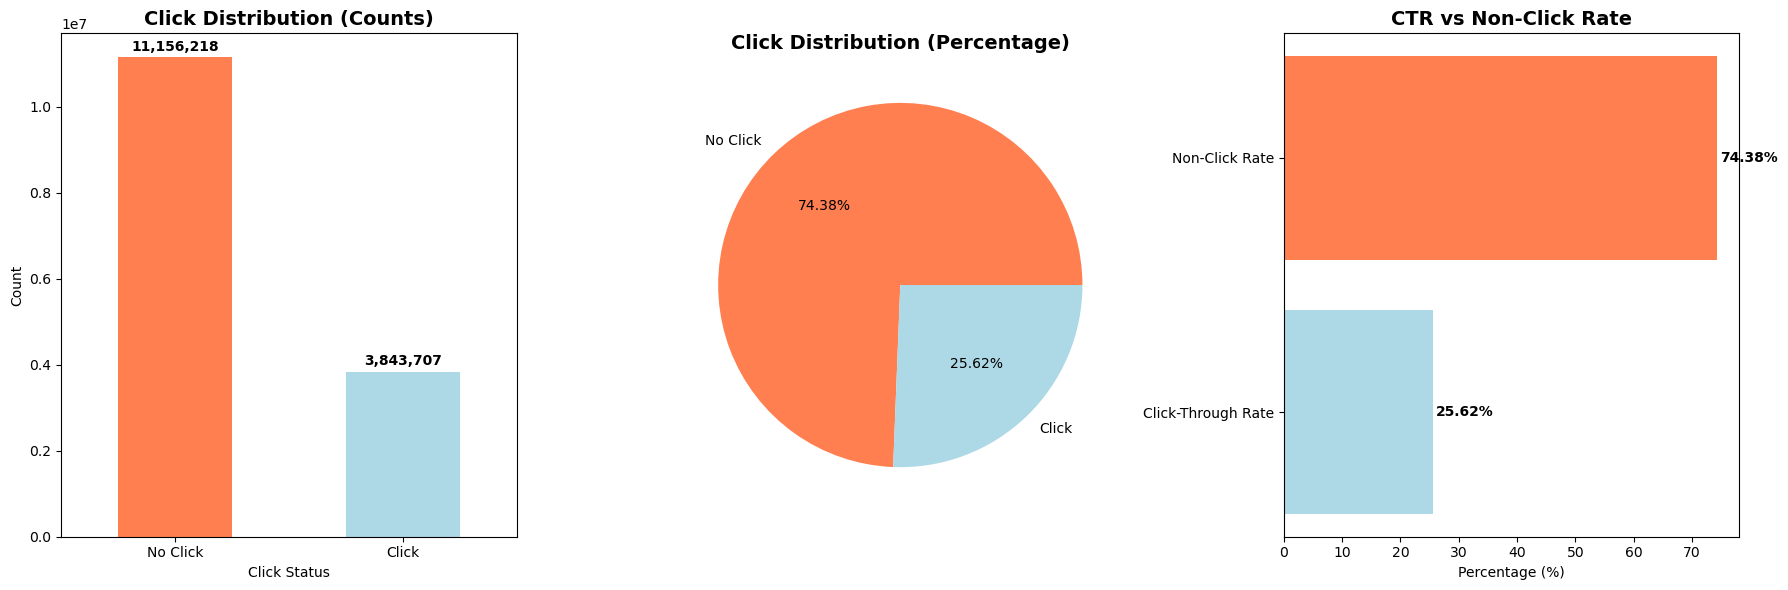


KEY INSIGHTS:
• This is a highly imbalanced classification problem
• CTR is 25.625%, which is typical for display advertising
• Will need to handle class imbalance in modeling (SMOTE, class weights, etc.)
• Precision and Recall will be more important than Accuracy


In [45]:
# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Bar plot
click_counts.plot(kind='bar', ax=axes[0], color=['coral', 'lightblue'])
axes[0].set_title('Click Distribution (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Click Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Click', 'Click'], rotation=0)

# Add count labels on bars
for i, v in enumerate(click_counts.values):
    axes[0].text(i, v + len(data)*0.01, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
click_counts.plot(kind='pie', ax=axes[1], autopct='%1.2f%%', 
                  colors=['coral', 'lightblue'], labels=['No Click', 'Click'])
axes[1].set_title('Click Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

# CTR visualization
ctr_data = pd.DataFrame({
    'Metric': ['Click-Through Rate', 'Non-Click Rate'], 
    'Percentage': [click_rates[1]*100, click_rates[0]*100]
})
axes[2].barh(ctr_data['Metric'], ctr_data['Percentage'], color=['lightblue', 'coral'])
axes[2].set_title('CTR vs Non-Click Rate', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Percentage (%)')

for i, v in enumerate(ctr_data['Percentage']):
    axes[2].text(v + 0.5, i, f'{v:.2f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Print key insights
print("\nKEY INSIGHTS:")
print(f"• This is a highly imbalanced classification problem")
print(f"• CTR is {click_rates[1]:.3%}, which is typical for display advertising")
print(f"• Will need to handle class imbalance in modeling (SMOTE, class weights, etc.)")
print(f"• Precision and Recall will be more important than Accuracy")

In [46]:
# Integer Features Analysis
print("INTEGER FEATURES ANALYSIS (I1 - I13)")
print("=" * 60)

integer_cols = [col for col in data.columns if col.startswith('I')]
print(f"Number of Integer Features: {len(integer_cols)}")
print(f"Features: {integer_cols}")

# Statistical summary for integer features
int_stats = data[integer_cols].describe().round(2)
print("\nStatistical Summary:")
int_stats

INTEGER FEATURES ANALYSIS (I1 - I13)
Number of Integer Features: 13
Features: ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13']

Statistical Summary:


,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13
count,8193400.00,14999925.00,11780559.00,11746758.00,14612737.00,11643521.00,14350722.00,14992497.00,14350722.00,8193400.00,14350722.00,3524203.00,11746758.00
mean,3.50,105.87,27.09,7.32,18569.69,116.12,16.33,12.52,106.03,0.62,2.73,0.99,8.21
std,9.31,389.72,405.69,8.79,69731.51,391.49,67.52,16.70,219.82,0.68,5.19,5.75,15.98
min,0.00,-3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,2.00,2.00,328.00,8.00,1.00,2.00,10.00,0.00,1.00,0.00,2.00
50%,1.00,3.00,6.00,4.00,2815.00,32.00,3.00,7.00,38.00,1.00,1.00,0.00,4.00
75%,3.00,35.00,18.00,10.00,10136.00,102.00,11.00,19.00,109.00,1.00,3.00,1.00,10.00
max,2047.00,27673.00,65535.00,969.00,23159456.00,431037.00,56311.00,5838.00,20065.00,11.00,176.00,4008.00,6944.00


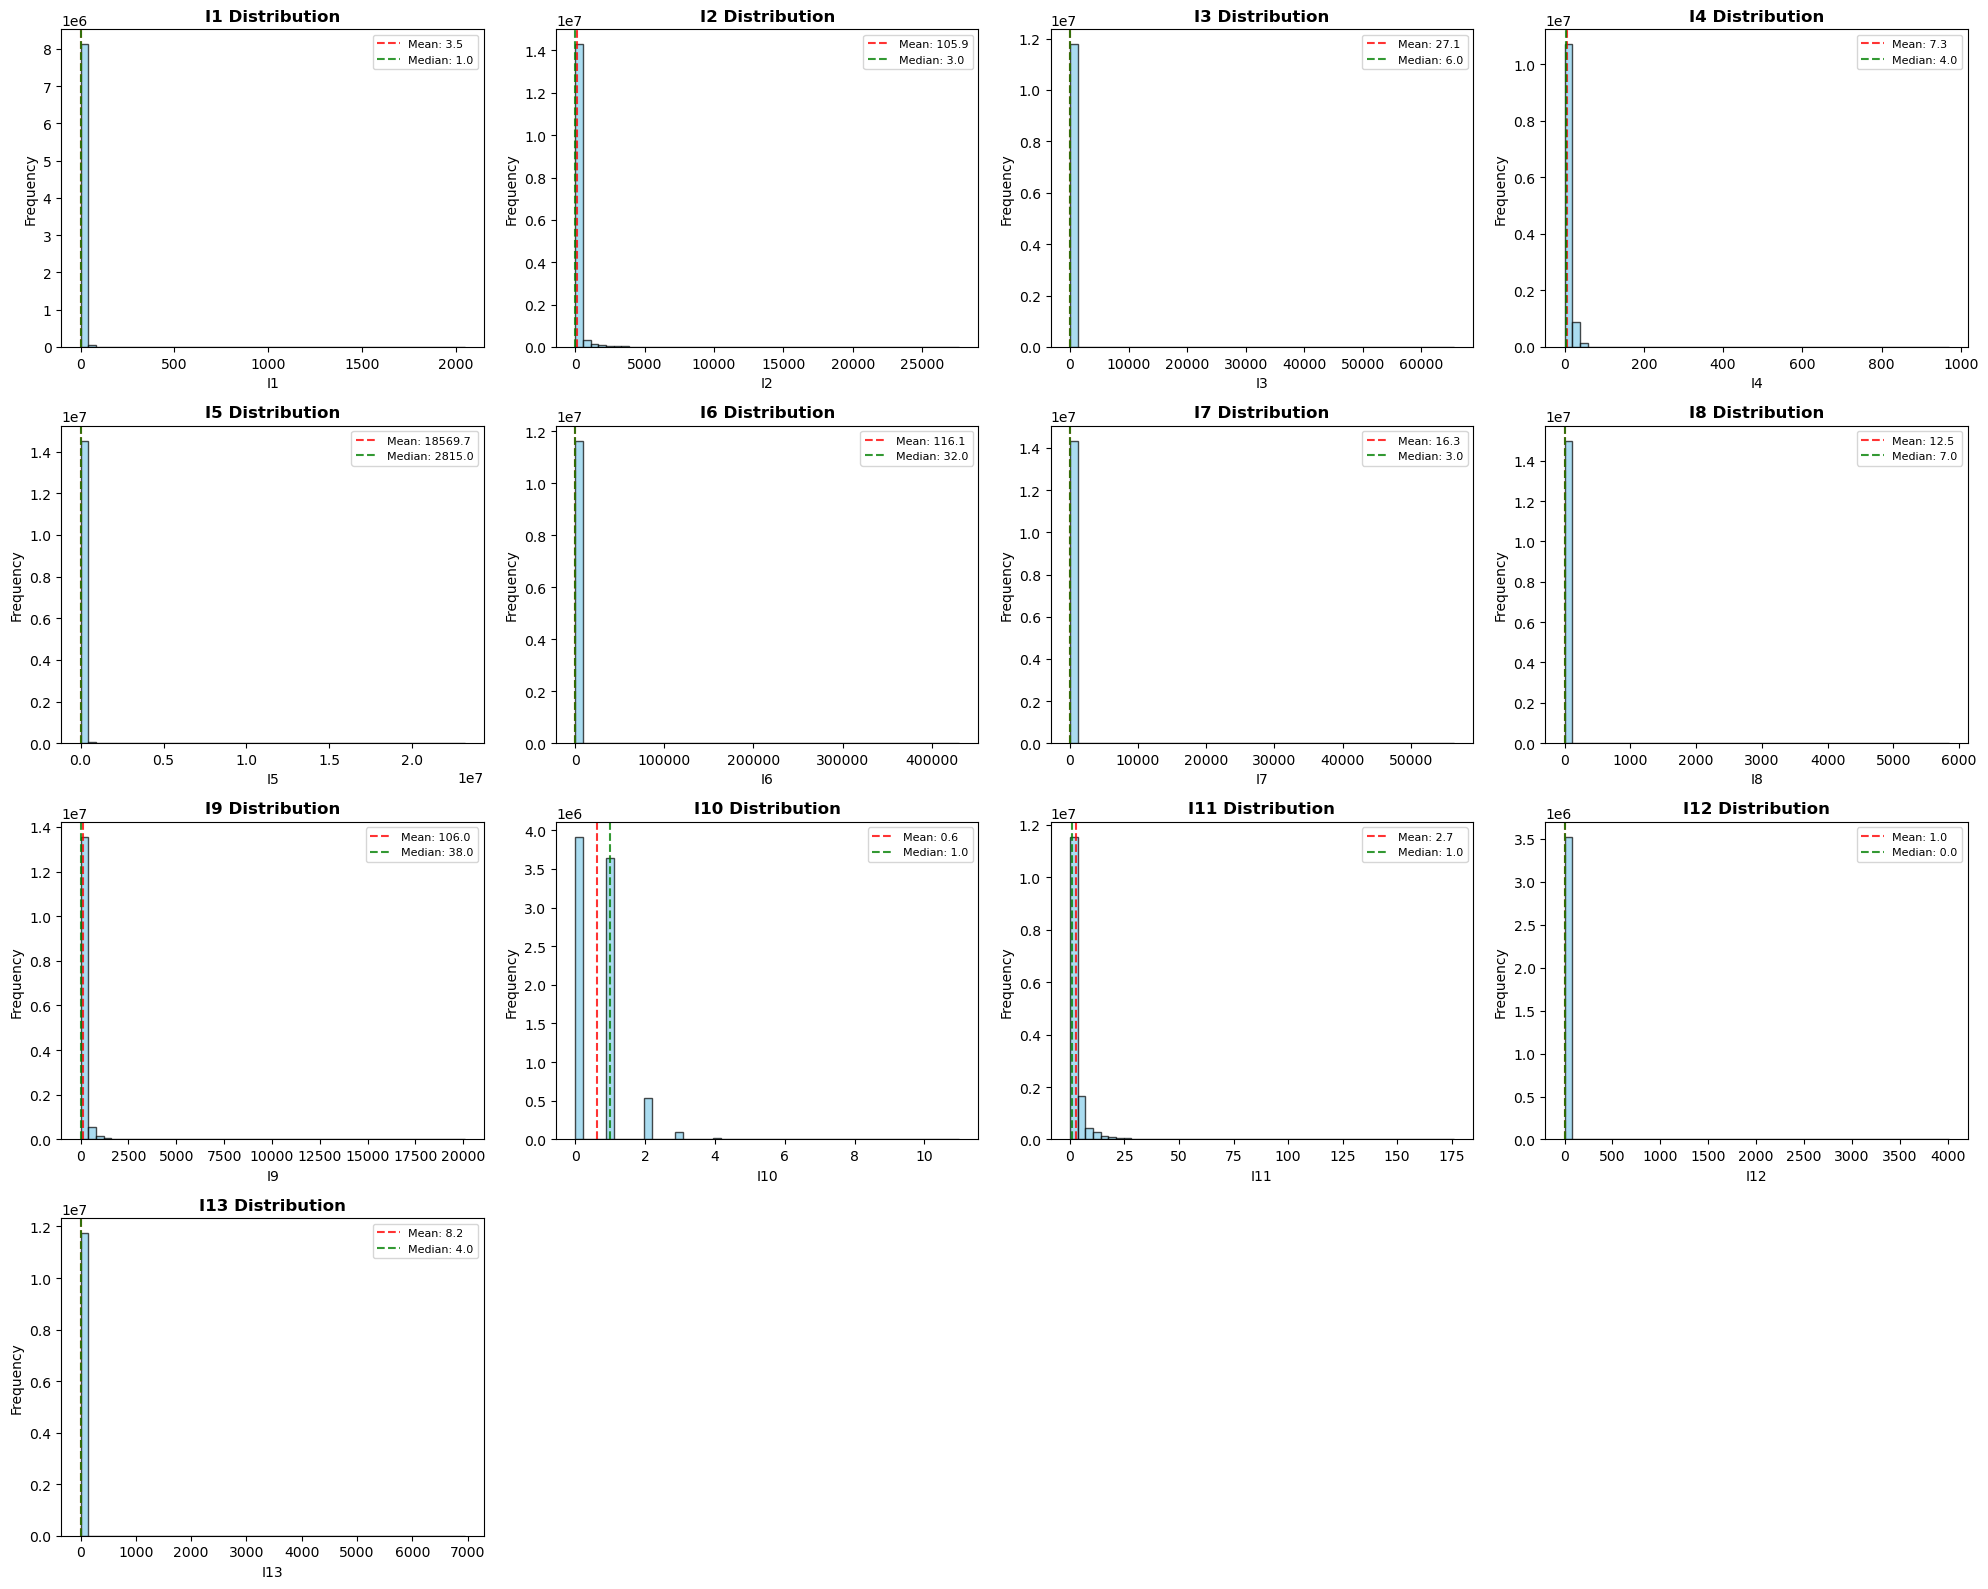

In [47]:
# Distribution analysis for integer features
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for i, col in enumerate(integer_cols):
    if i < len(axes):
        # Handle missing values for plotting
        col_data = data[col].dropna()
        
        if len(col_data) > 0:
            axes[i].hist(col_data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
            axes[i].set_title(f'{col} Distribution', fontweight='bold')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
            
            # Add statistics text
            mean_val = col_data.mean()
            median_val = col_data.median()
            axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.1f}')
            axes[i].axvline(median_val, color='green', linestyle='--', alpha=0.8, label=f'Median: {median_val:.1f}')
            axes[i].legend(fontsize=8)
        else:
            axes[i].text(0.5, 0.5, 'No Data', ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{col} - No Data')

# Remove empty subplots
for i in range(len(integer_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

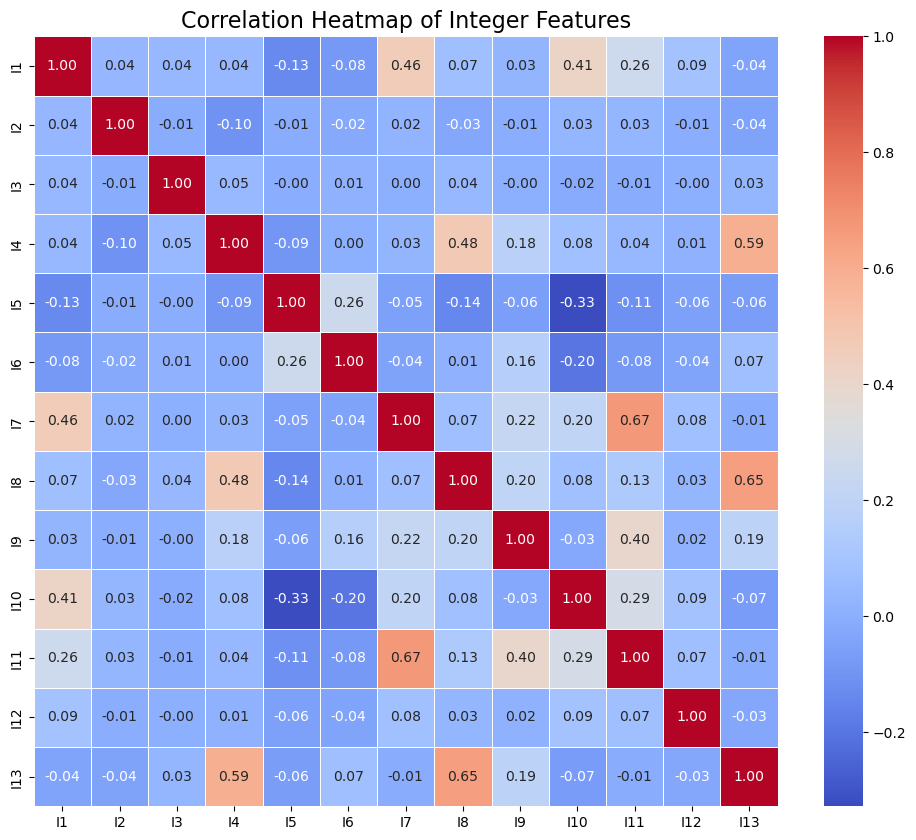

In [48]:
# Calculate the correlation matrix for integer features
integer_features = ['I' + str(i) for i in range(1, 14)]
correlation_matrix = data[integer_features].corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap of Integer Features', fontsize=16)
plt.show()

In [49]:
# Integer features vs CTR analysis
print("INTEGER FEATURES vs CTR RELATIONSHIP")
print("=" * 50)

# Calculate CTR by binned integer features
ctr_by_int_features = {}

for col in integer_cols:
    if data[col].notna().sum() > 0:
        # Create bins for analysis
        data_temp = data[[col, 'click']].dropna()
        
        if len(data_temp) > 0:
            # Use quantile-based binning to handle skewed distributions
            try:
                data_temp['binned'] = pd.qcut(data_temp[col], q=10, duplicates='drop')
                ctr_by_bin = data_temp.groupby('binned')['click'].agg(['count', 'sum', 'mean']).round(4)
                ctr_by_bin.columns = ['Total_Ads', 'Clicks', 'CTR']
                ctr_by_int_features[col] = ctr_by_bin
            except:
                # Fallback to simple binning if quantile binning fails
                data_temp['binned'] = pd.cut(data_temp[col], bins=5, duplicates='drop')
                ctr_by_bin = data_temp.groupby('binned')['click'].agg(['count', 'sum', 'mean']).round(4)
                ctr_by_bin.columns = ['Total_Ads', 'Clicks', 'CTR']
                ctr_by_int_features[col] = ctr_by_bin

# Display CTR analysis for first few features
for i, (feature, ctr_data) in enumerate(list(ctr_by_int_features.items())[:3]):
    print(f"\n{feature} vs CTR:")
    print(ctr_data)

INTEGER FEATURES vs CTR RELATIONSHIP

I1 vs CTR:
               Total_Ads   Clicks     CTR
binned                                   
(-0.001, 1.0]    4916863  1245836  0.2534
(1.0, 3.0]       1292722   479499  0.3709
(3.0, 4.0]        369765   146220  0.3954
(4.0, 9.0]        860515   359102  0.4173
(9.0, 2047.0]     753535   336701  0.4468

I2 vs CTR:
                  Total_Ads  Clicks     CTR
binned                                     
(-3.001, -1.0]      1553095  484106  0.3117
(-1.0, 0.0]         2608222  616215  0.2363
(0.0, 1.0]          2320327  546156  0.2354
(1.0, 3.0]          1313829  300379  0.2286
(3.0, 9.0]          1367577  315022  0.2304
(9.0, 23.0]         1403073  338171  0.2410
(23.0, 56.0]        1448188  362246  0.2501
(56.0, 184.0]       1490590  399251  0.2678
(184.0, 27673.0]    1495024  482161  0.3225

I3 vs CTR:
                 Total_Ads  Clicks     CTR
binned                                    
(-0.001, 1.0]      1933281  569776  0.2947
(1.0, 2.0]         1

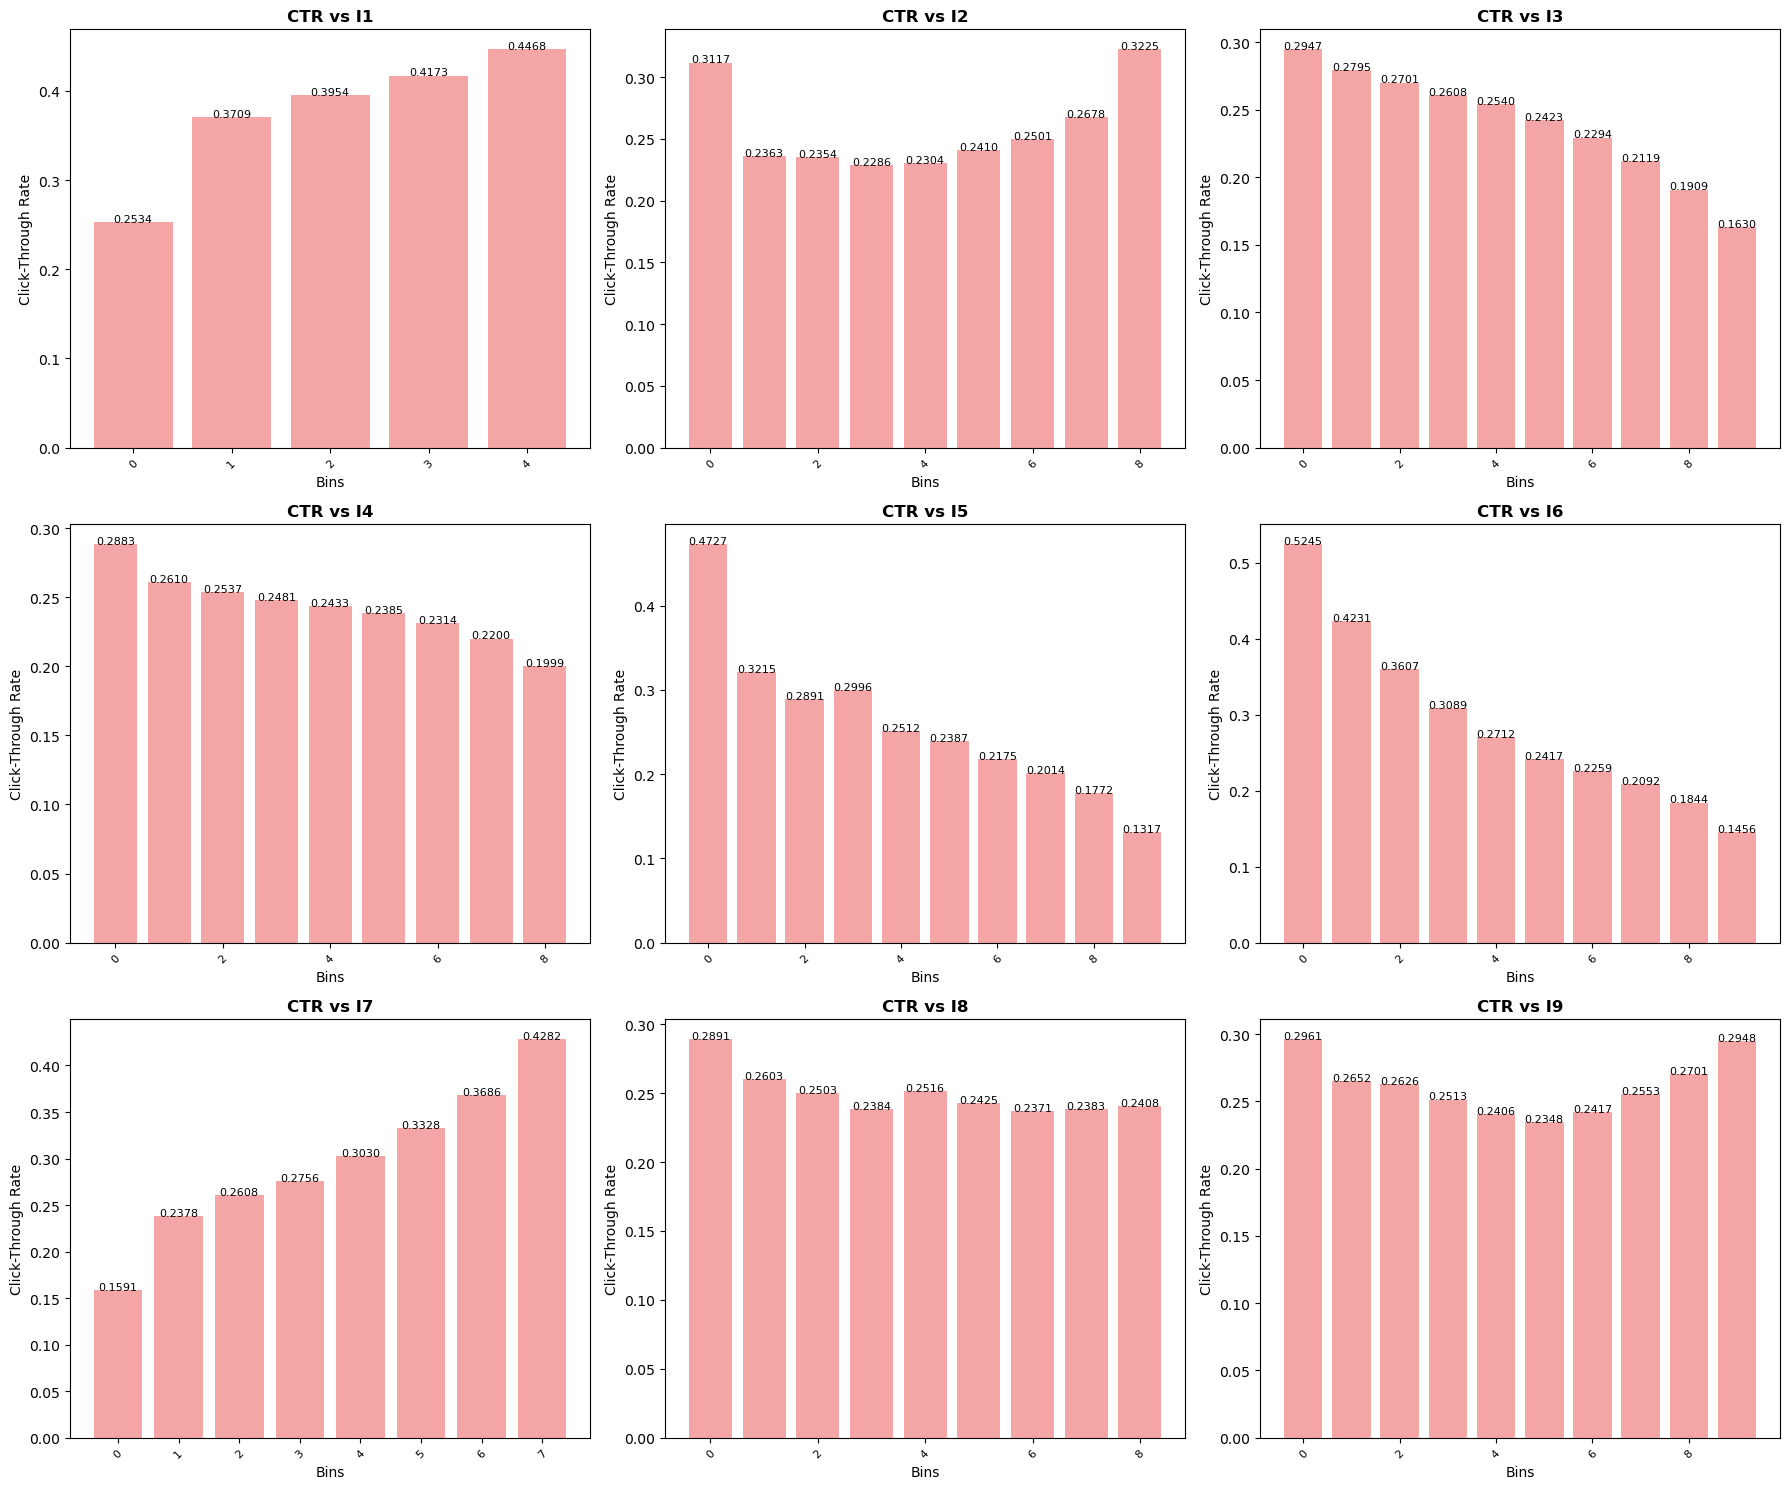

In [50]:
# Visualize CTR vs Integer Features
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

plot_count = 0
for feature, ctr_data in list(ctr_by_int_features.items())[:9]:
    if plot_count < len(axes):
        # Plot CTR by bins
        bin_labels = [str(x) for x in ctr_data.index]
        axes[plot_count].bar(range(len(ctr_data)), ctr_data['CTR'], color='lightcoral', alpha=0.7)
        axes[plot_count].set_title(f'CTR vs {feature}', fontweight='bold')
        axes[plot_count].set_xlabel('Bins')
        axes[plot_count].set_ylabel('Click-Through Rate')
        axes[plot_count].tick_params(axis='x', rotation=45, labelsize=8)
        
        # Add value labels on bars
        for i, v in enumerate(ctr_data['CTR']):
            axes[plot_count].text(i, v + 0.0001, f'{v:.4f}', ha='center', fontsize=8)
        
        plot_count += 1

# Remove empty subplots
for i in range(plot_count, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

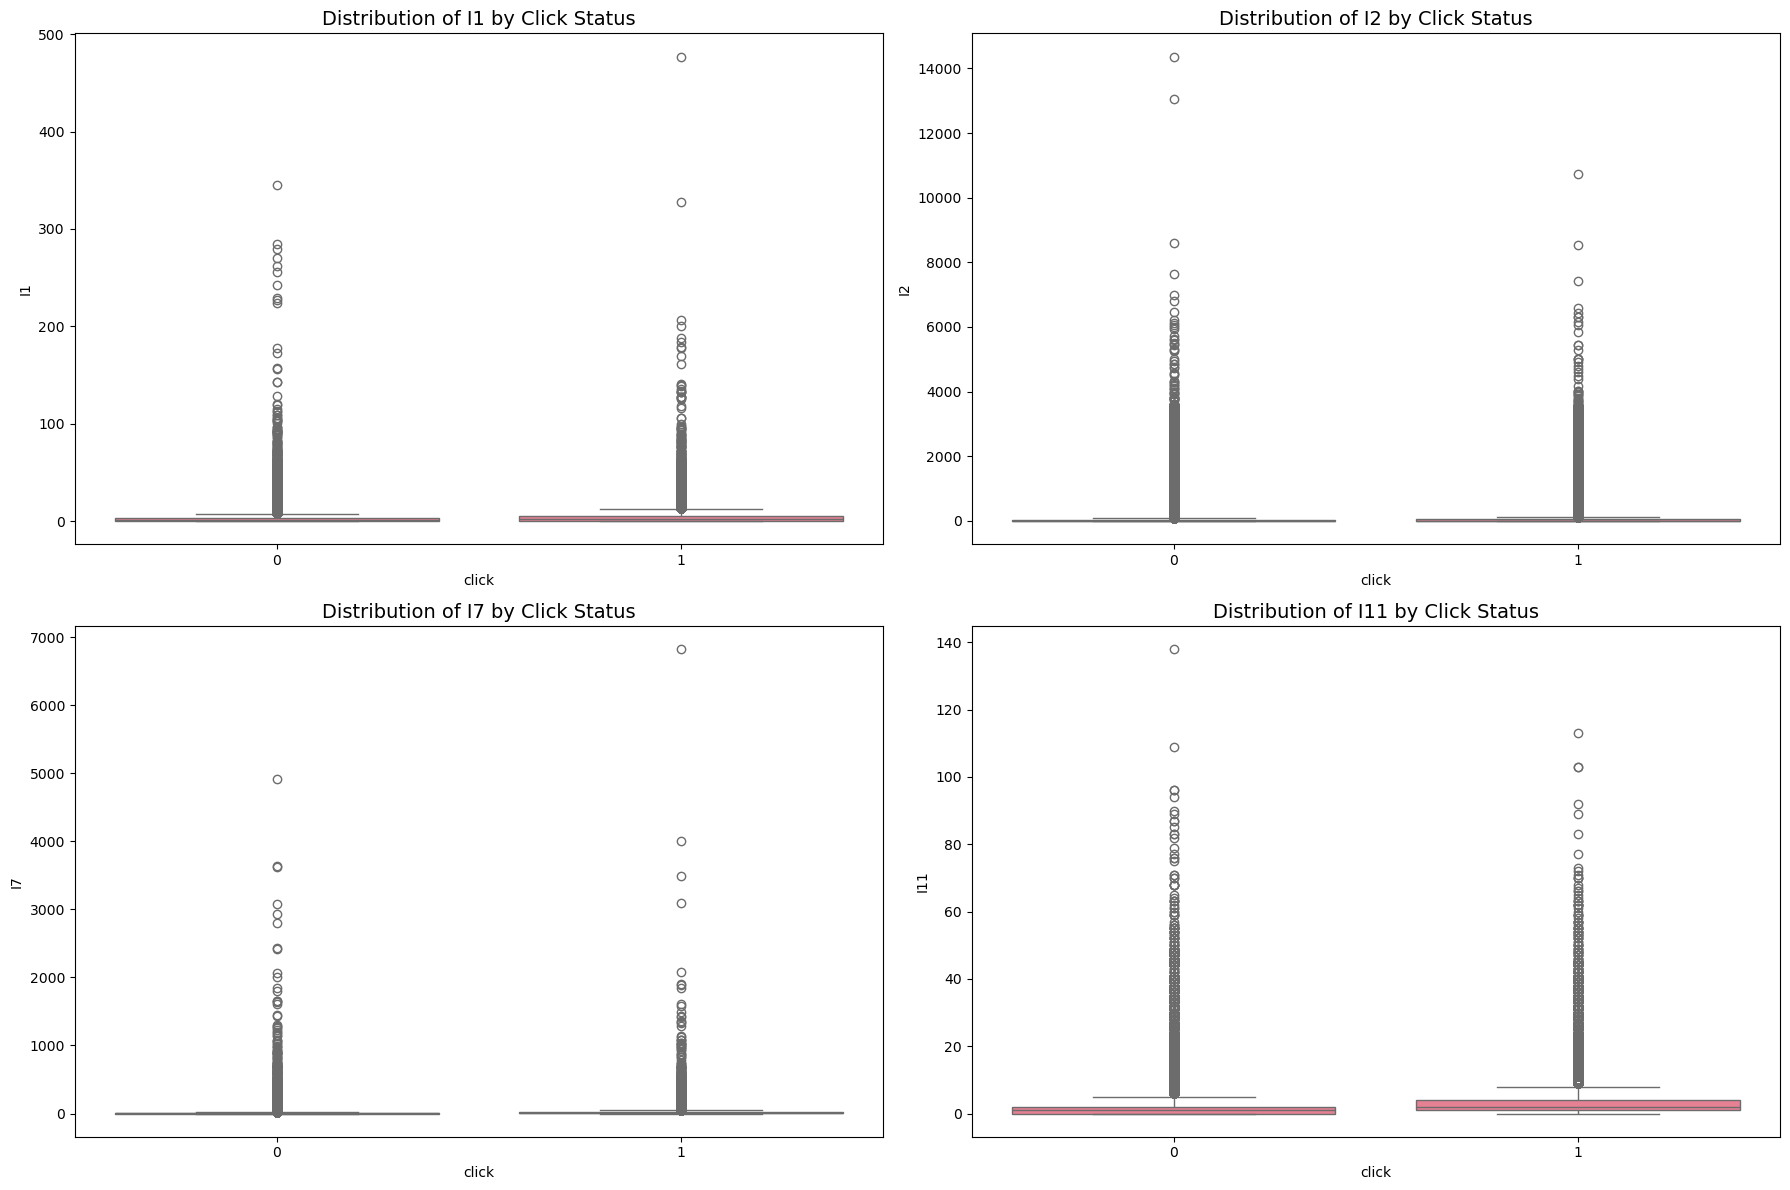

In [51]:
# Visualize the distribution for a few key integer features against the 'click' variable
# Picking a few to avoid clutter.
features_to_plot = ['I1', 'I2', 'I7', 'I11']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    # We'll plot a sample to avoid performance issues with very large data
    sns.boxplot(x='click', y=feature, data=data.sample(n=100000, random_state=42))
    plt.title(f'Distribution of {feature} by Click Status', fontsize=14)

plt.tight_layout()
plt.show()

In [52]:
# Categorical Features Analysis
print("CATEGORICAL FEATURES ANALYSIS (C1 - C26)")
print("=" * 60)

categorical_cols = [col for col in data.columns if col.startswith('C')]
print(f"Number of Categorical Features: {len(categorical_cols)}")
print(f"Features: {categorical_cols}")

# Cardinality analysis
cat_cardinality = []
for col in categorical_cols:
    unique_count = data[col].nunique(dropna=False)
    null_count = data[col].isnull().sum()
    null_pct = (null_count / len(data)) * 100
    
    cat_cardinality.append({
        'Feature': col,
        'Unique_Values': unique_count,
        'Null_Count': null_count,
        'Null_Percentage': round(null_pct, 2),
        'Cardinality_Type': 'High' if unique_count > 1000 else 'Medium' if unique_count > 100 else 'Low'
    })

cat_df = pd.DataFrame(cat_cardinality)
print("\nCategorical Features Cardinality:")
cat_df.sort_values('Unique_Values', ascending=False)

CATEGORICAL FEATURES ANALYSIS (C1 - C26)
Number of Categorical Features: 26
Features: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26']

Categorical Features Cardinality:


,Feature,Unique_Values,Null_Count,Null_Percentage,Cardinality_Type
2,C3,3891658,510972,3.41,High
11,C12,3300847,510972,3.41,High
20,C21,2848749,510972,3.41,High
15,C16,2262728,510972,3.41,High
3,C4,1000585,510972,3.41,High
23,C24,171777,510972,3.41,High
25,C26,99278,6601016,44.01,High
9,C10,72773,0,0.00,High
14,C15,13671,0,0.00,High
6,C7,12355,0,0.00,High


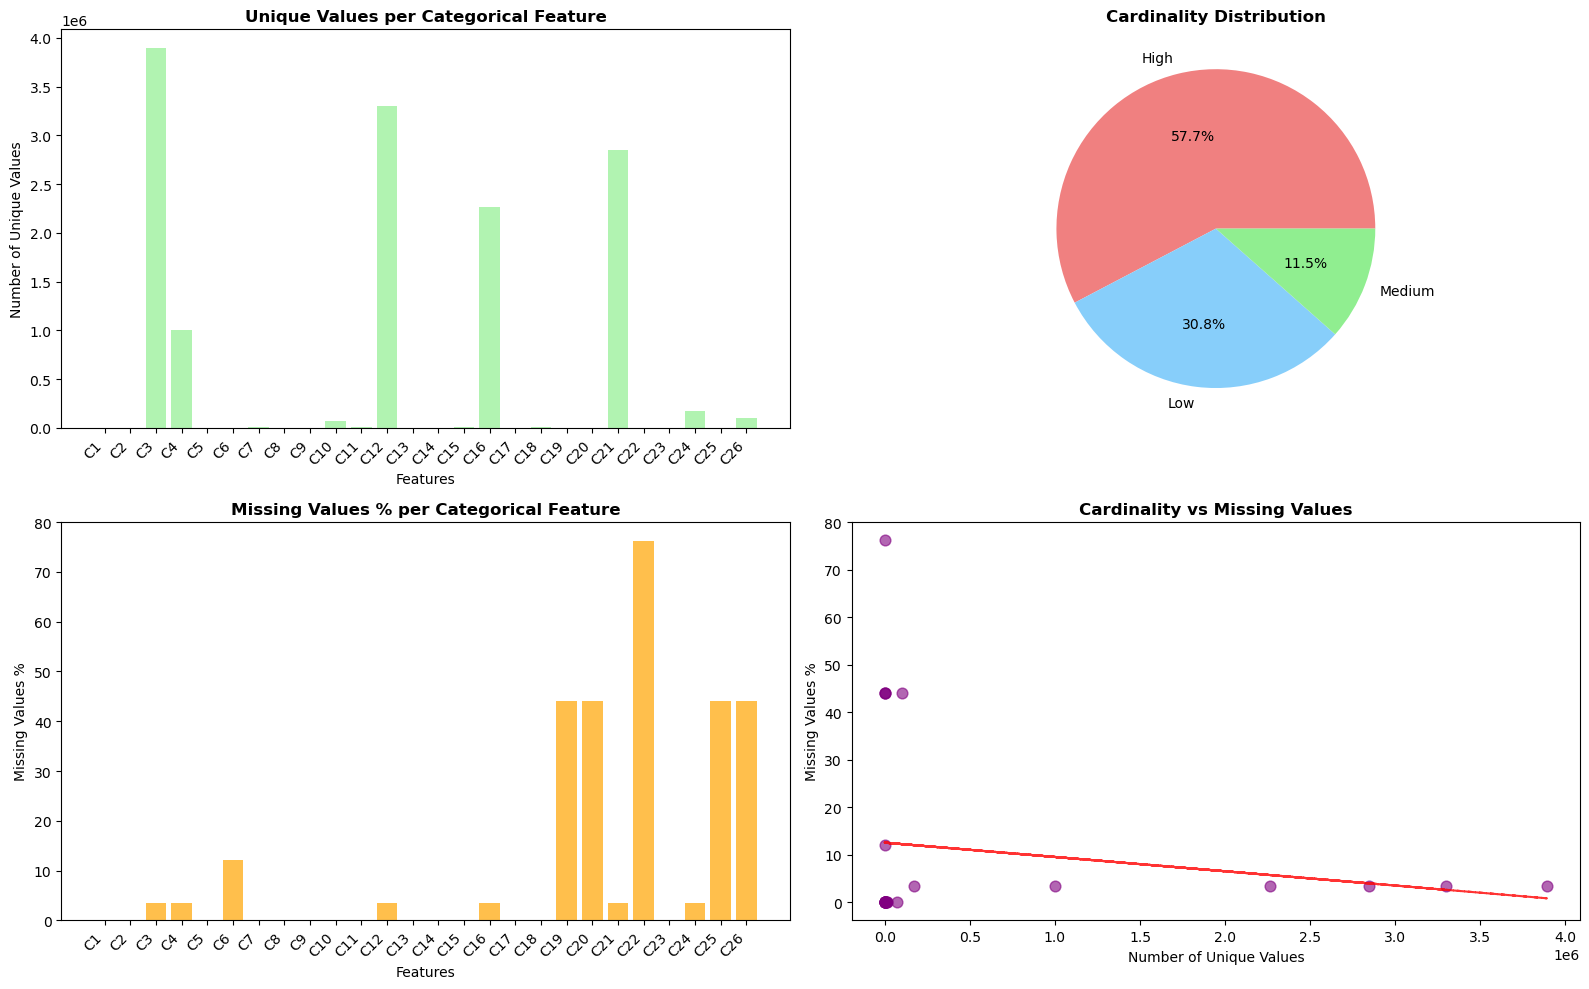

In [53]:
# Visualize cardinality distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Unique values distribution
axes[0,0].bar(range(len(cat_df)), cat_df['Unique_Values'], color='lightgreen', alpha=0.7)
axes[0,0].set_title('Unique Values per Categorical Feature', fontweight='bold')
axes[0,0].set_xlabel('Features')
axes[0,0].set_ylabel('Number of Unique Values')
axes[0,0].set_xticks(range(len(cat_df)))
axes[0,0].set_xticklabels(cat_df['Feature'], rotation=45, ha='right')

# Cardinality type distribution
cardinality_counts = cat_df['Cardinality_Type'].value_counts()
axes[0,1].pie(cardinality_counts.values, labels=cardinality_counts.index, autopct='%1.1f%%',
              colors=['lightcoral', 'lightskyblue', 'lightgreen'])
axes[0,1].set_title('Cardinality Distribution', fontweight='bold')

# Missing values percentage
axes[1,0].bar(range(len(cat_df)), cat_df['Null_Percentage'], color='orange', alpha=0.7)
axes[1,0].set_title('Missing Values % per Categorical Feature', fontweight='bold')
axes[1,0].set_xlabel('Features')
axes[1,0].set_ylabel('Missing Values %')
axes[1,0].set_xticks(range(len(cat_df)))
axes[1,0].set_xticklabels(cat_df['Feature'], rotation=45, ha='right')

# Correlation between cardinality and missing values
axes[1,1].scatter(cat_df['Unique_Values'], cat_df['Null_Percentage'], 
                  color='purple', alpha=0.6, s=60)
axes[1,1].set_title('Cardinality vs Missing Values', fontweight='bold')
axes[1,1].set_xlabel('Number of Unique Values')
axes[1,1].set_ylabel('Missing Values %')

# Add trend line
z = np.polyfit(cat_df['Unique_Values'], cat_df['Null_Percentage'], 1)
p = np.poly1d(z)
axes[1,1].plot(cat_df['Unique_Values'], p(cat_df['Unique_Values']), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

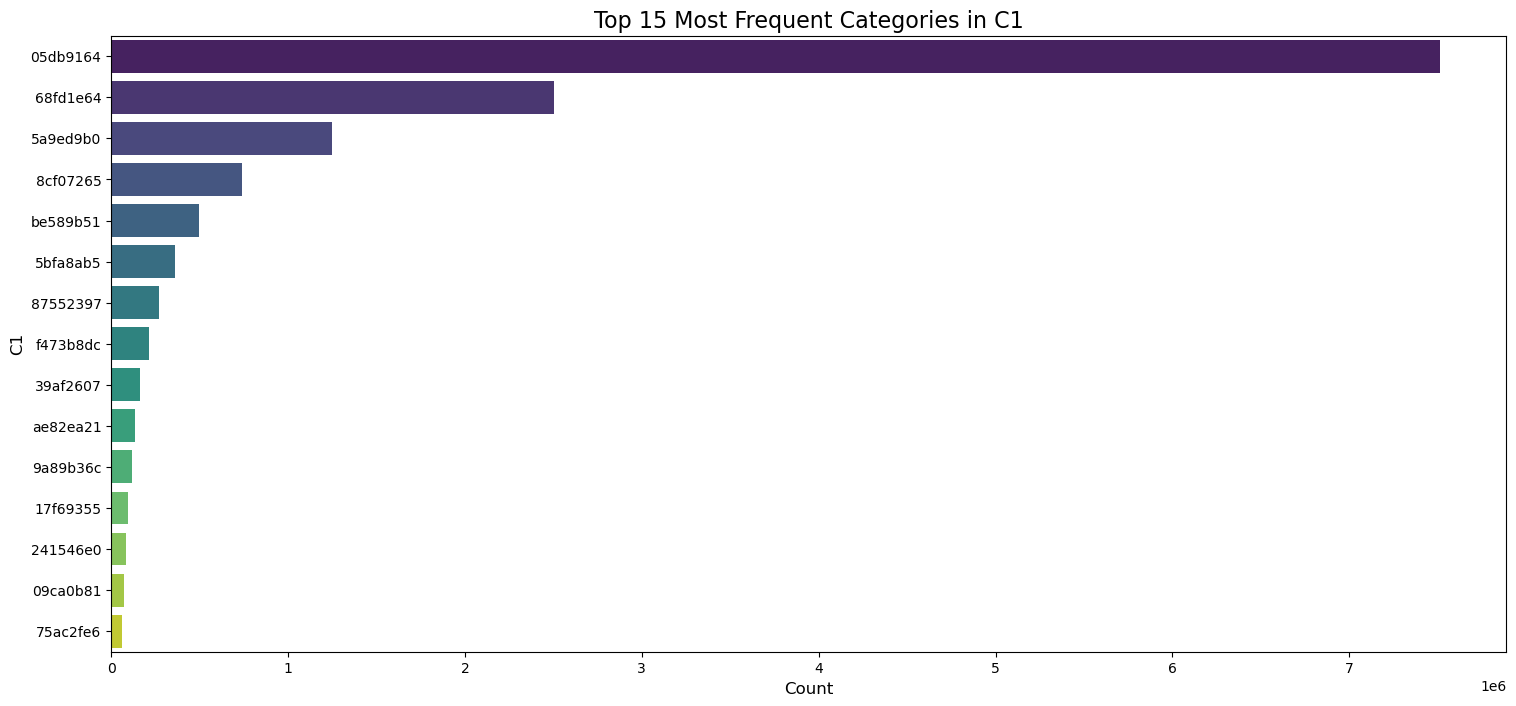

In [54]:
# Visualize the frequency of the top 15 categories for feature C1
feature_to_plot = 'C1'
top_n = 15

# Get the top N categories
top_categories = data[feature_to_plot].value_counts().nlargest(top_n).index

# Filter the data to include only top categories
data_top_cat = data[data[feature_to_plot].isin(top_categories)]

plt.figure(figsize=(18, 8))
sns.countplot(y=feature_to_plot, data=data_top_cat, order=top_categories, palette='viridis')
plt.title(f'Top {top_n} Most Frequent Categories in {feature_to_plot}', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel(feature_to_plot, fontsize=12)
plt.show()

In [55]:
# Top values analysis for selected categorical features
print("TOP VALUES ANALYSIS FOR KEY CATEGORICAL FEATURES")
print("=" * 60)

# Select features with medium cardinality for analysis
medium_card_features = cat_df[cat_df['Cardinality_Type'] == 'Medium']['Feature'].tolist()
if not medium_card_features:
    medium_card_features = categorical_cols[:5]  # Fallback to first 5

for feature in medium_card_features[:3]:  # Analyze first 3
    print(f"\n{feature} - Top 10 Values:")
    top_values = data[feature].value_counts().head(10)
    print(top_values)
    
    # Calculate CTR for top values
    feature_ctr = data.groupby(feature)['click'].agg(['count', 'sum', 'mean']).round(4)
    feature_ctr.columns = ['Total_Ads', 'Clicks', 'CTR']
    feature_ctr = feature_ctr.sort_values('Total_Ads', ascending=False).head(10)
    
    print(f"\nCTR by {feature} (Top 10 by volume):")
    print(feature_ctr)

TOP VALUES ANALYSIS FOR KEY CATEGORICAL FEATURES

C2 - Top 10 Values:
C2
38a947a1    1717134
207b2d81     647044
38d50e09     574896
1cfdf714     543857
287130e0     535924
4f25e98b     486261
09e68b86     473145
421b43cd     392129
58e67aaf     357885
80e26c9b     339641
Name: count, dtype: int64

CTR by C2 (Top 10 by volume):
          Total_Ads  Clicks     CTR
C2                                 
38a947a1    1717134  533112  0.3105
207b2d81     647044  119552  0.1848
38d50e09     574896  100731  0.1752
1cfdf714     543857  150555  0.2768
287130e0     535924  133831  0.2497
4f25e98b     486261  110095  0.2264
09e68b86     473145  106008  0.2240
421b43cd     392129  109079  0.2782
58e67aaf     357885   98425  0.2750
80e26c9b     339641   71169  0.2095

C5 - Top 10 Values:
C5
25c83c98    10073048
4cf72387     2346069
43b19349      947788
384874ce      491280
30903e74      289107
0942e0a7      188395
f281d2a7      128413
b0530c50       89648
b2241560       69720
f3474129       53589
Name

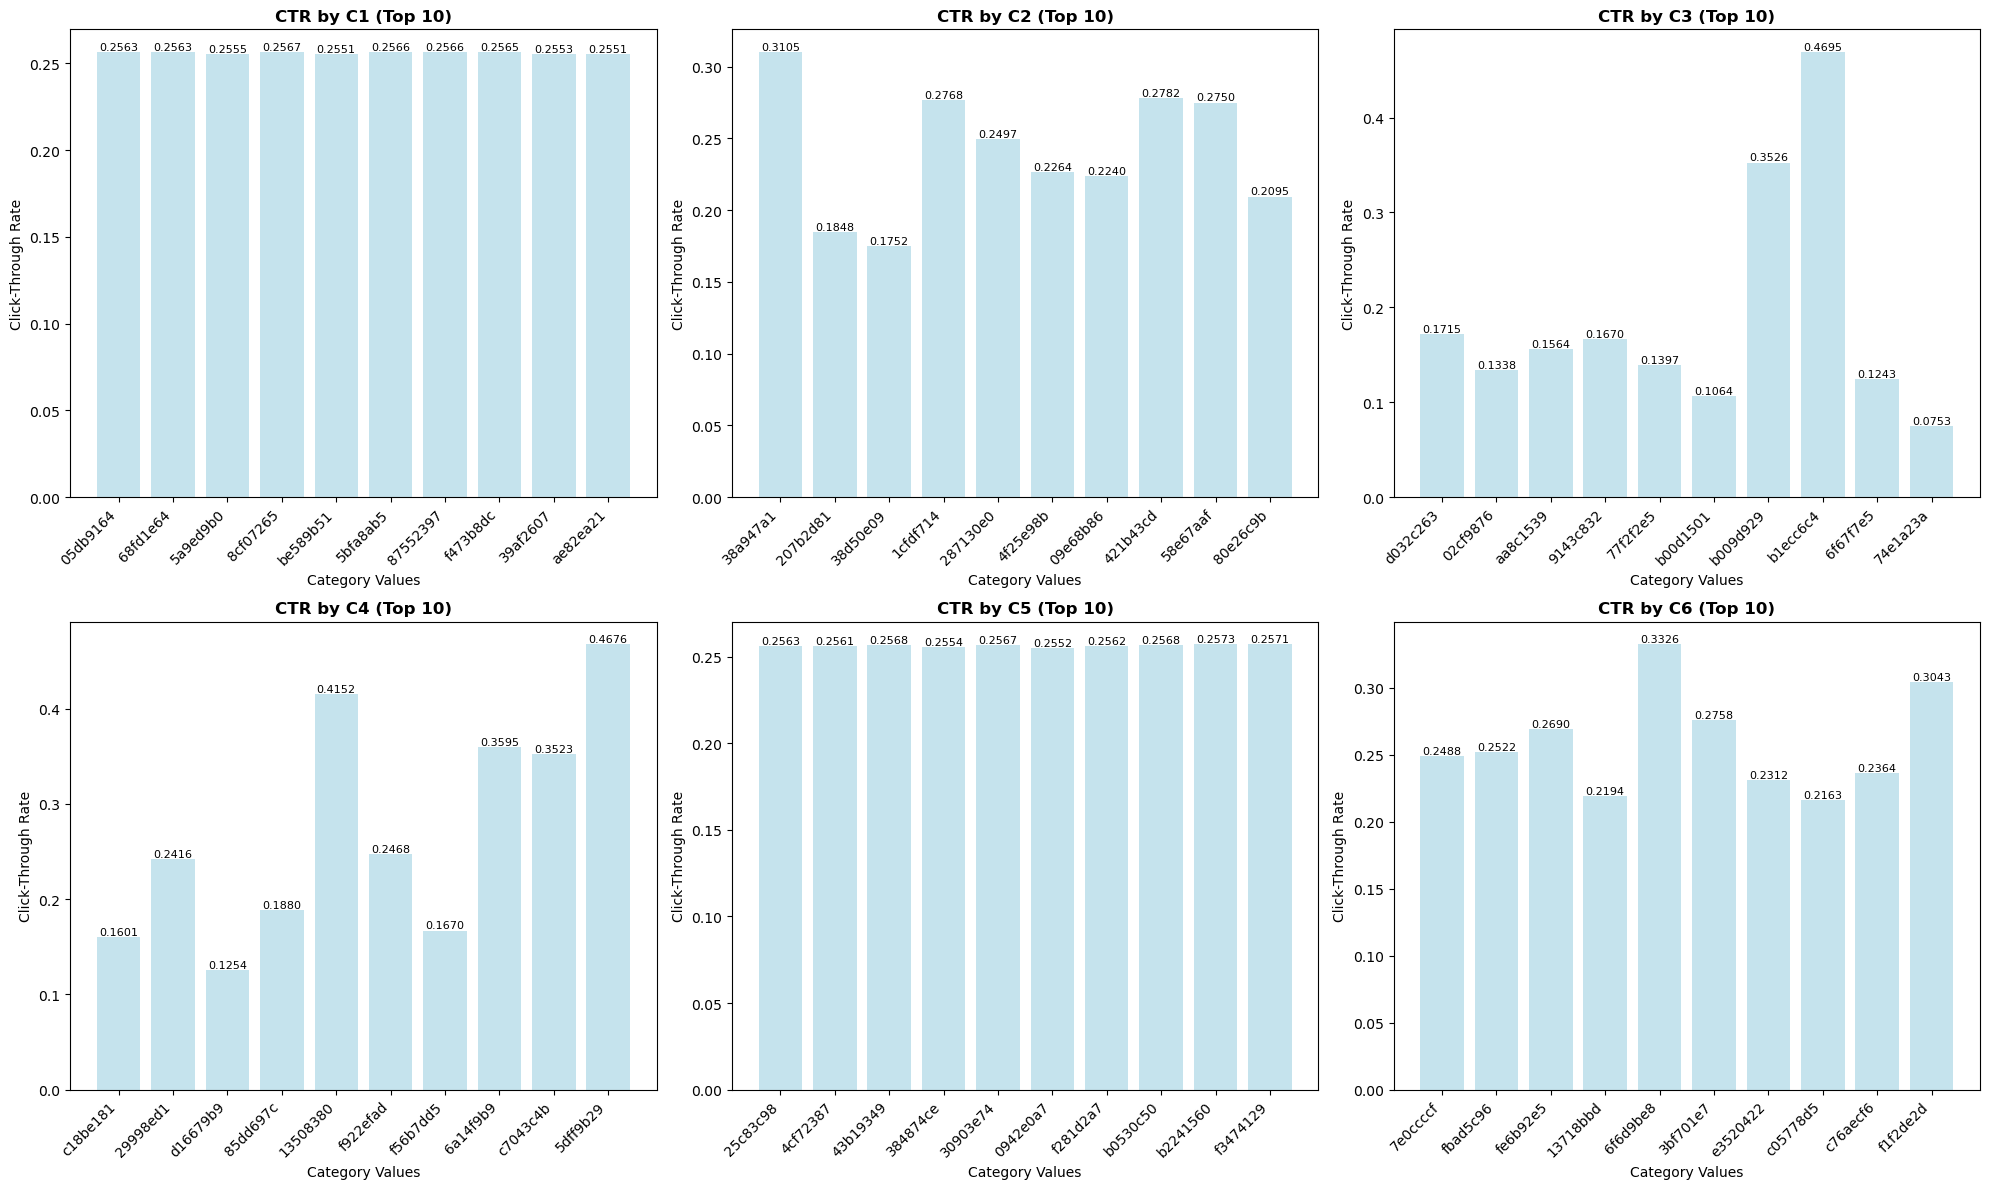

In [56]:
# CTR analysis by categorical features
def analyze_categorical_ctr(feature, top_n=15):
    """Analyze CTR for categorical feature values"""
    
    # Get top N values by frequency
    top_values = data[feature].value_counts().head(top_n).index
    filtered_data = data[data[feature].isin(top_values)]
    
    # Calculate CTR for each value
    ctr_analysis = filtered_data.groupby(feature)['click'].agg([
        ('Total_Ads', 'count'),
        ('Clicks', 'sum'), 
        ('CTR', 'mean'),
        ('CTR_std', 'std')
    ]).round(4)
    
    return ctr_analysis.sort_values('Total_Ads', ascending=False)

# Analyze a few key categorical features
key_features = categorical_cols[:6]  # First 6 categorical features

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    if i < len(axes):
        ctr_data = analyze_categorical_ctr(feature, top_n=10)
        
        # Plot CTR
        bars = axes[i].bar(range(len(ctr_data)), ctr_data['CTR'], color='lightblue', alpha=0.7)
        axes[i].set_title(f'CTR by {feature} (Top 10)', fontweight='bold')
        axes[i].set_xlabel('Category Values')
        axes[i].set_ylabel('Click-Through Rate')
        axes[i].set_xticks(range(len(ctr_data)))
        axes[i].set_xticklabels([str(x)[:8] for x in ctr_data.index], rotation=45, ha='right')
        
        # Add value labels
        for j, bar in enumerate(bars):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.00005,
                        f'{height:.4f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [57]:
# Comprehensive Missing Values Analysis
print("🕳️ MISSING VALUES ANALYSIS")
print("=" * 60)

# Calculate missing values
missing_analysis = []
for col in data.columns:
    missing_count = data[col].isnull().sum()
    missing_pct = (missing_count / len(data)) * 100
    
    missing_analysis.append({
        'Feature': col,
        'Missing_Count': missing_count,
        'Missing_Percentage': round(missing_pct, 2),
        'Data_Type': 'Target' if col == 'click' else ('Integer' if col.startswith('I') else 'Categorical'),
        'Has_Missing': 'Yes' if missing_count > 0 else 'No'
    })

missing_df = pd.DataFrame(missing_analysis)

# Summary statistics
print("MISSING VALUES SUMMARY:")
print(f"Features with missing values: {missing_df['Has_Missing'].value_counts()['Yes']} out of {len(missing_df)}")
print(f"Total missing values: {missing_df['Missing_Count'].sum():,}")
print(f"Overall missing percentage: {(missing_df['Missing_Count'].sum() / (len(data) * len(data.columns))) * 100:.2f}%")

print("\nFeatures with Missing Values:")
features_with_missing = missing_df[missing_df['Has_Missing'] == 'Yes'].sort_values('Missing_Percentage', ascending=False)
features_with_missing

🕳️ MISSING VALUES ANALYSIS
MISSING VALUES SUMMARY:
Features with missing values: 24 out of 40
Total missing values: 83,231,128
Overall missing percentage: 13.87%

Features with Missing Values:


,Feature,Missing_Count,Missing_Percentage,Data_Type,Has_Missing
12,I12,11475722,76.51,Integer,Yes
35,C22,11436281,76.24,Categorical,Yes
1,I1,6806525,45.38,Integer,Yes
10,I10,6806525,45.38,Integer,Yes
38,C25,6601016,44.01,Categorical,Yes
33,C20,6601016,44.01,Categorical,Yes
32,C19,6601016,44.01,Categorical,Yes
39,C26,6601016,44.01,Categorical,Yes
6,I6,3356404,22.38,Integer,Yes
13,I13,3253167,21.69,Integer,Yes


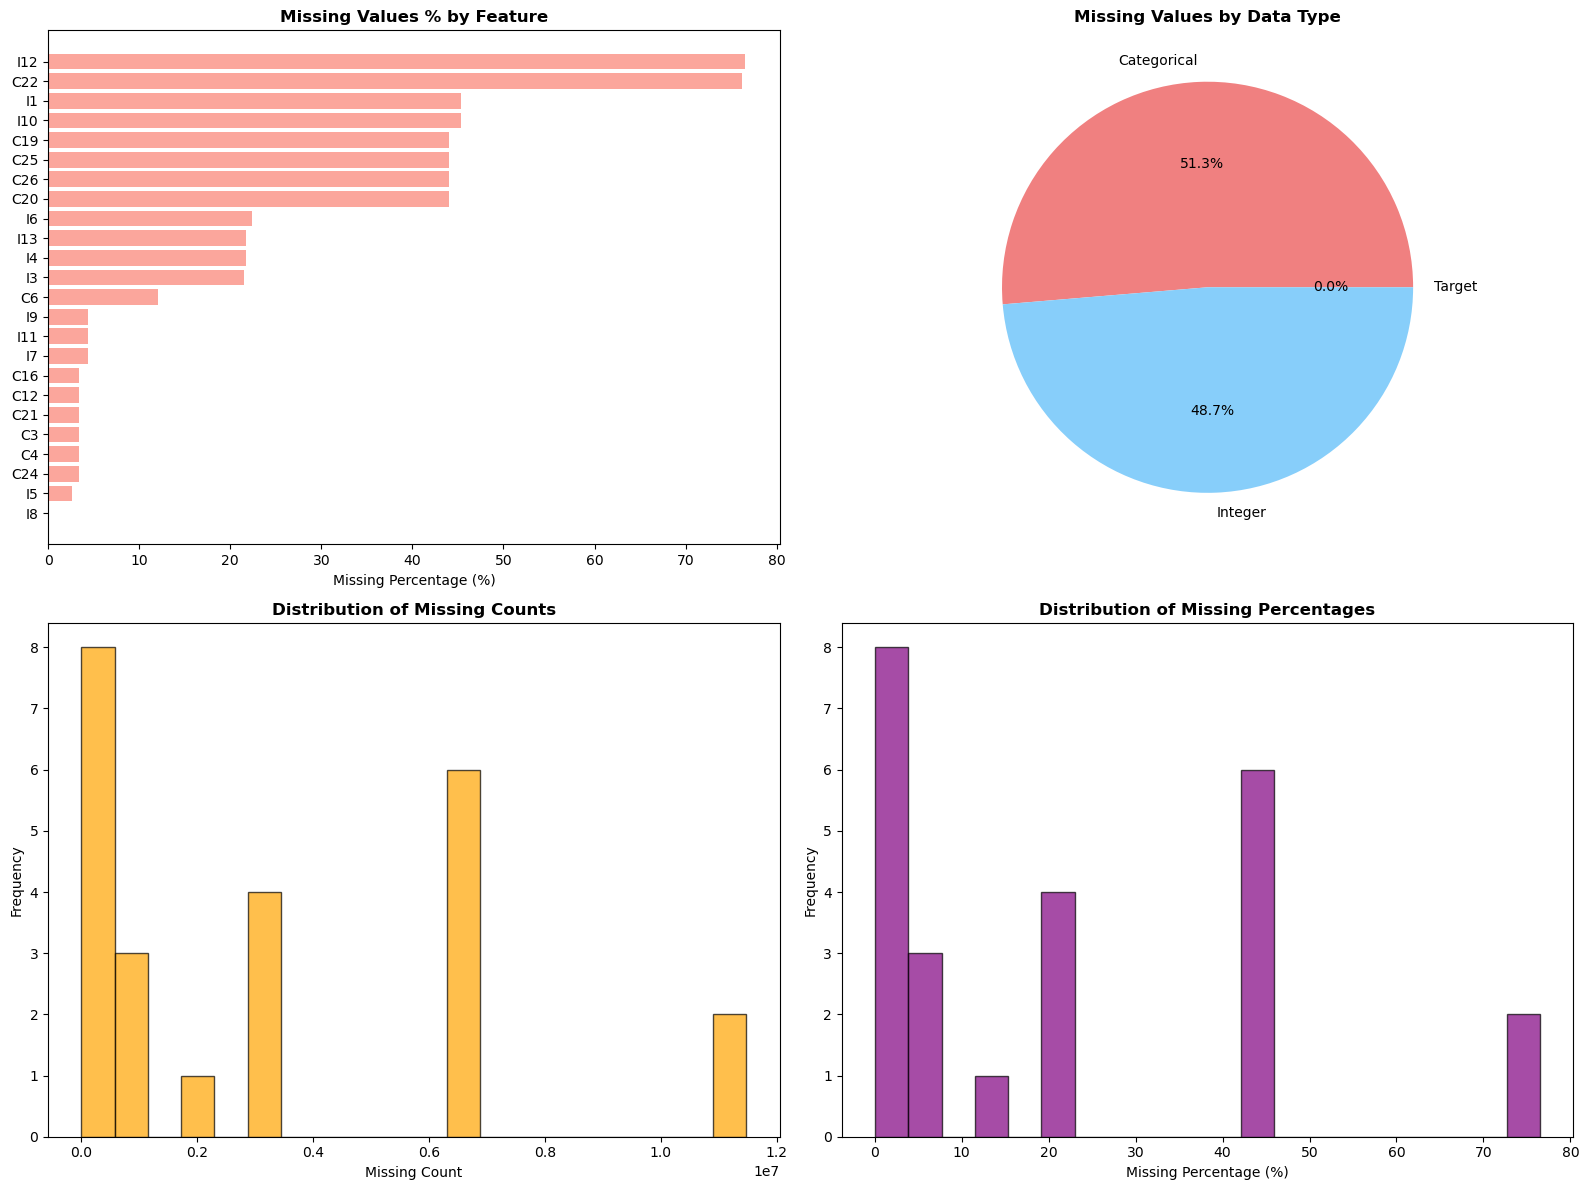

In [58]:
# Visualize missing values pattern
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Missing values by feature
features_with_missing_viz = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=True)

if len(features_with_missing_viz) > 0:
    axes[0,0].barh(features_with_missing_viz['Feature'], features_with_missing_viz['Missing_Percentage'], 
                   color='salmon', alpha=0.7)
    axes[0,0].set_title('Missing Values % by Feature', fontweight='bold')
    axes[0,0].set_xlabel('Missing Percentage (%)')
    
    # Missing values by data type
    missing_by_type = missing_df.groupby('Data_Type')['Missing_Count'].sum()
    axes[0,1].pie(missing_by_type.values, labels=missing_by_type.index, autopct='%1.1f%%',
                  colors=['lightcoral', 'lightskyblue', 'lightgreen'])
    axes[0,1].set_title('Missing Values by Data Type', fontweight='bold')
    
    # Missing values count distribution
    missing_counts = missing_df[missing_df['Missing_Count'] > 0]['Missing_Count']
    axes[1,0].hist(missing_counts, bins=20, color='orange', alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Distribution of Missing Counts', fontweight='bold')
    axes[1,0].set_xlabel('Missing Count')
    axes[1,0].set_ylabel('Frequency')
    
    # Missing percentage distribution
    missing_pcts = missing_df[missing_df['Missing_Percentage'] > 0]['Missing_Percentage']
    axes[1,1].hist(missing_pcts, bins=20, color='purple', alpha=0.7, edgecolor='black')
    axes[1,1].set_title('Distribution of Missing Percentages', fontweight='bold')
    axes[1,1].set_xlabel('Missing Percentage (%)')
    axes[1,1].set_ylabel('Frequency')
    
else:
    for ax in axes.flatten():
        ax.text(0.5, 0.5, 'No Missing Values Found!', ha='center', va='center', 
               transform=ax.transAxes, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [59]:
# Missing values pattern analysis
if len(features_with_missing) > 0:
    print("MISSING VALUES PATTERN ANALYSIS")
    print("=" * 50)
    
    # Check if missing values are correlated between features
    features_with_missing_list = features_with_missing['Feature'].tolist()
    
    if len(features_with_missing_list) > 1:
        # Create missing value indicator matrix
        missing_matrix = data[features_with_missing_list].isnull()
        
        # Calculate correlation between missing patterns
        missing_corr = missing_matrix.corr()
        
        print("Missing Values Correlation Matrix (Top correlated pairs):")
        # Get upper triangle of correlation matrix
        mask = np.triu(np.ones_like(missing_corr, dtype=bool))
        missing_corr_masked = missing_corr.mask(mask)
        
        # Find high correlations
        high_corr_pairs = []
        for i in range(len(missing_corr_masked.columns)):
            for j in range(len(missing_corr_masked.index)):
                corr_val = missing_corr_masked.iloc[i, j]
                if not pd.isna(corr_val) and abs(corr_val) > 0.1:
                    high_corr_pairs.append({
                        'Feature1': missing_corr_masked.columns[i],
                        'Feature2': missing_corr_masked.index[j],
                        'Correlation': round(corr_val, 3)
                    })
        
        if high_corr_pairs:
            high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
            print(high_corr_df.head(10))
        else:
            print("No strong correlations found between missing value patterns")
    
    # Missing values impact on CTR
    print(f"\nMISSING VALUES IMPACT ON CTR:")
    for feature in features_with_missing_list[:5]:  # Top 5 features with missing values
        missing_ctr = data.groupby(data[feature].isnull())['click'].mean()
        print(f"{feature}:")
        print(f"  CTR when present: {missing_ctr[False]:.4f}")
        if True in missing_ctr.index:
            print(f"  CTR when missing: {missing_ctr[True]:.4f}")
            print(f"  Difference: {(missing_ctr[False] - missing_ctr[True]):.4f}")
        print()

else:
    print("✅ No missing values found in the dataset!")

MISSING VALUES PATTERN ANALYSIS
Missing Values Correlation Matrix (Top correlated pairs):
   Feature1 Feature2  Correlation
67      C21      C16          1.0
45       I7      I11          1.0
65      C21       C4          1.0
72      C24       C4          1.0
38      I11       I9          1.0
73      C24      C12          1.0
74      C24      C16          1.0
44       I7       I9          1.0
84       C3      C24          1.0
59      C16       C4          1.0

MISSING VALUES IMPACT ON CTR:
I12:
  CTR when present: 0.2882
  CTR when missing: 0.2464
  Difference: 0.0418

C22:
  CTR when present: 0.2812
  CTR when missing: 0.2485
  Difference: 0.0327

I1:
  CTR when present: 0.3133
  CTR when missing: 0.1875
  Difference: 0.1258

I10:
  CTR when present: 0.3133
  CTR when missing: 0.1875
  Difference: 0.1258

C25:
  CTR when present: 0.2460
  CTR when missing: 0.2692
  Difference: -0.0232



FEATURE RELATIONSHIPS & CORRELATIONS
INTEGER FEATURES CORRELATION ANALYSIS


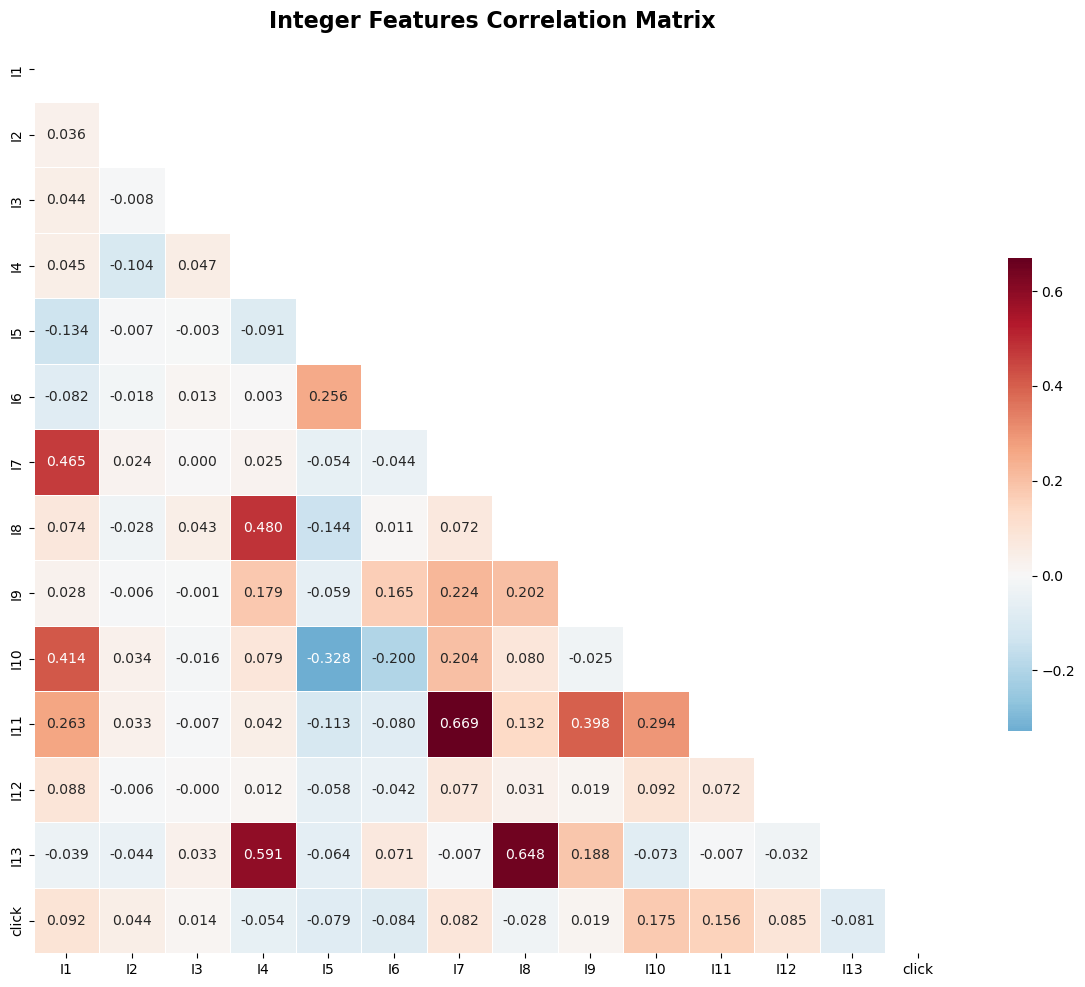


Strongest correlations with CTR (click):
  I10: 0.1745 (positive)
  I11: 0.1558 (positive)
  I1: 0.0922 (positive)
  I12: 0.0849 (positive)
  I6: -0.0842 (negative)
  I7: 0.0819 (positive)
  I13: -0.0810 (negative)
  I5: -0.0793 (negative)
  I4: -0.0540 (negative)
  I2: 0.0445 (positive)


In [60]:
# Feature Relationships Analysis
print("FEATURE RELATIONSHIPS & CORRELATIONS")
print("=" * 60)

# Correlation analysis for integer features
print("INTEGER FEATURES CORRELATION ANALYSIS")
int_corr = data[integer_cols + ['click']].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(int_corr, dtype=bool))
sns.heatmap(int_corr, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt='.3f')
plt.title('Integer Features Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find strongest correlations with target
target_corr = int_corr['click'].abs().sort_values(ascending=False)[1:]  # Exclude self-correlation
print(f"\nStrongest correlations with CTR (click):")
for feature, corr_val in target_corr.head(10).items():
    direction = "positive" if int_corr.loc[feature, 'click'] > 0 else "negative"
    print(f"  {feature}: {int_corr.loc[feature, 'click']:.4f} ({direction})")


🤝 FEATURE INTERACTIONS ANALYSIS


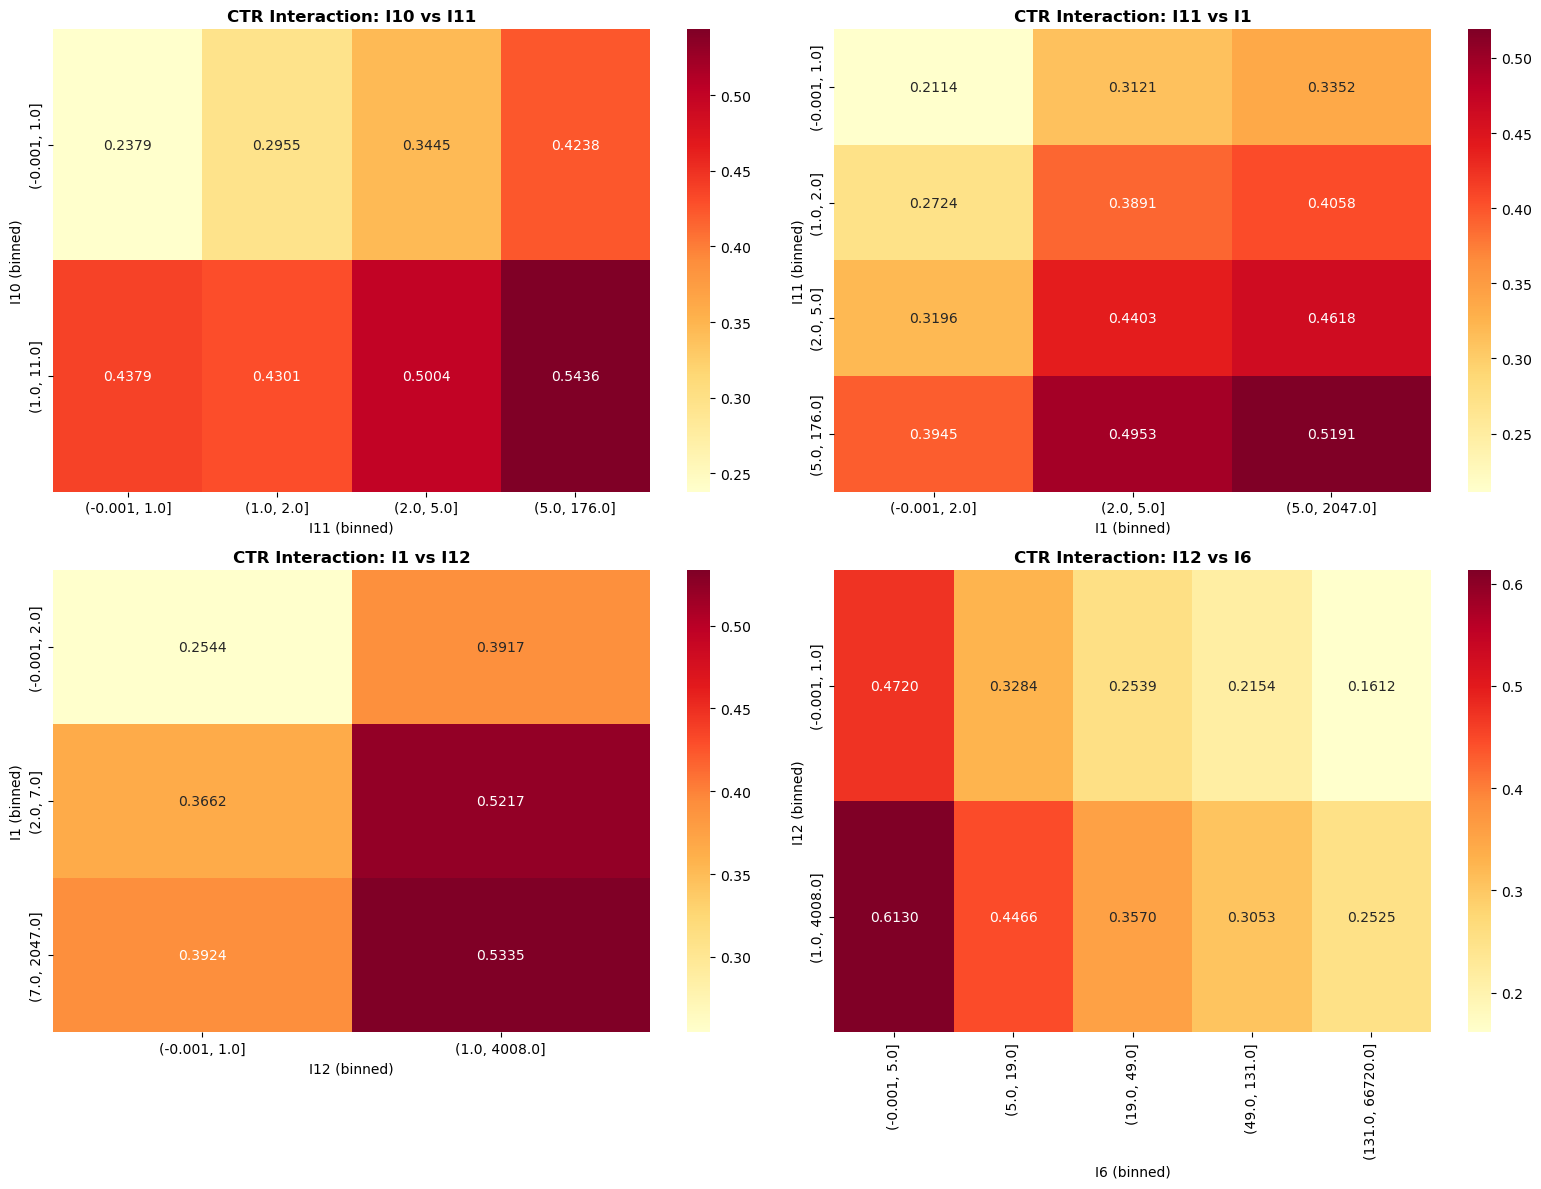

In [61]:
# Feature interactions analysis
print("\n🤝 FEATURE INTERACTIONS ANALYSIS")
print("=" * 50)

# Select top correlated features for interaction analysis
top_features = target_corr.head(5).index.tolist()

# Create interaction plots
if len(top_features) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    plot_idx = 0
    for i in range(len(top_features)-1):
        if plot_idx < 4:
            feature1, feature2 = top_features[i], top_features[i+1]
            
            # Create 2D histogram for interaction
            # Remove missing values for plotting
            plot_data = data[[feature1, feature2, 'click']].dropna()
            
            if len(plot_data) > 0:
                # Create bins for both features
                plot_data[f'{feature1}_binned'] = pd.qcut(plot_data[feature1], q=5, duplicates='drop')
                plot_data[f'{feature2}_binned'] = pd.qcut(plot_data[feature2], q=5, duplicates='drop')
                
                # Calculate CTR for each combination
                interaction_ctr = plot_data.groupby([f'{feature1}_binned', f'{feature2}_binned'])['click'].mean().unstack()
                
                # Plot heatmap
                sns.heatmap(interaction_ctr, annot=True, cmap='YlOrRd', ax=axes[plot_idx], fmt='.4f')
                axes[plot_idx].set_title(f'CTR Interaction: {feature1} vs {feature2}', fontweight='bold')
                axes[plot_idx].set_xlabel(f'{feature2} (binned)')
                axes[plot_idx].set_ylabel(f'{feature1} (binned)')
                
            plot_idx += 1
    
    # Remove unused subplots
    for i in range(plot_idx, 4):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

CATEGORICAL FEATURES vs CTR ANALYSIS
Categorical Features Association with CTR (Cramér's V):
  Feature  Cramers_V   P_Value Effect_Size
2      C3   0.598024  0.000000       Large
3      C4   0.395958  0.000000       Large
6      C7   0.281425  0.000000       Large
9     C10   0.212656  0.000000      Medium
1      C2   0.186860  0.000000      Medium
8      C9   0.100234  0.000000       Small
5      C6   0.040380  0.000000       Small
0      C1   0.010567  0.000065       Small
7      C8   0.006875  0.017809       Small
4      C5   0.004807  0.046392       Small


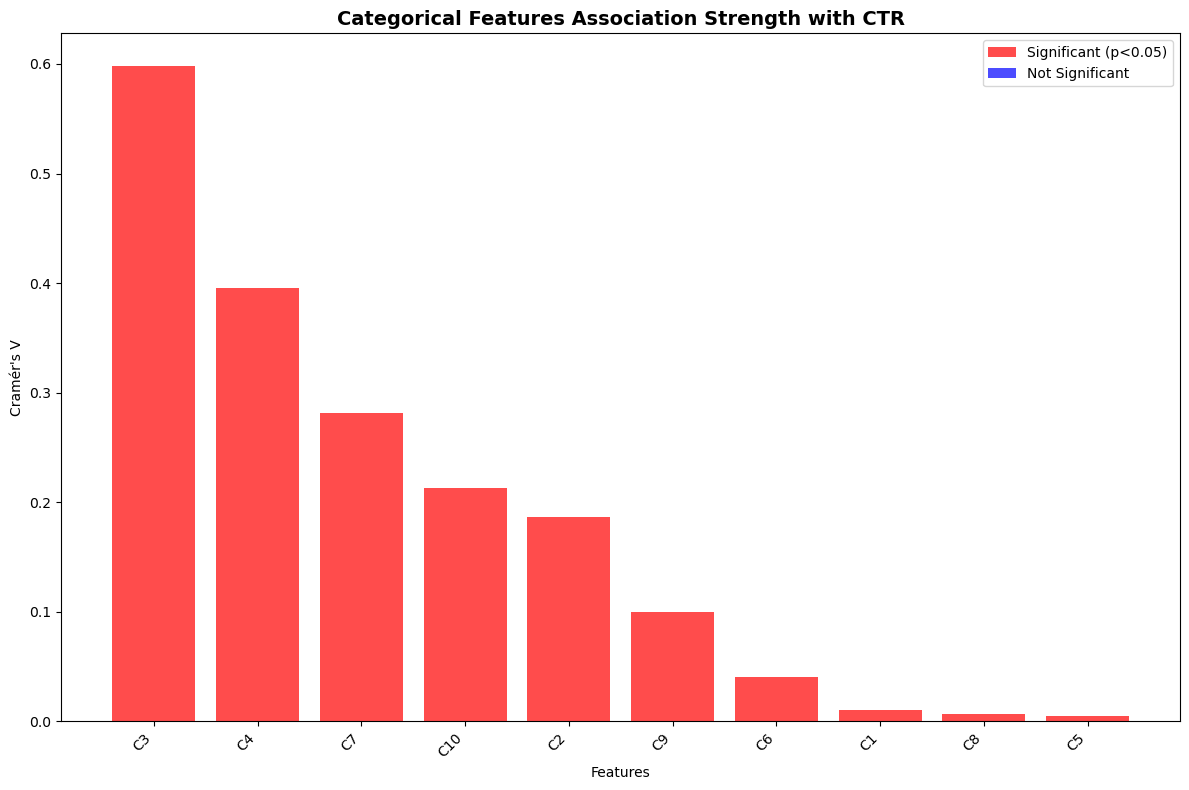

In [62]:
# Categorical features relationship with CTR
print("CATEGORICAL FEATURES vs CTR ANALYSIS")
print("=" * 50)

# Calculate mutual information or chi-square test for categorical features
from scipy.stats import chi2_contingency

categorical_ctr_strength = []

for feature in categorical_cols[:10]:  # Analyze first 10 categorical features
    # Remove missing values
    clean_data = data[[feature, 'click']].dropna()
    
    if len(clean_data) > 0 and clean_data[feature].nunique() > 1:
        try:
            # Create contingency table
            contingency_table = pd.crosstab(clean_data[feature], clean_data['click'])
            
            # Perform chi-square test
            chi2, p_value, dof, expected = chi2_contingency(contingency_table)
            
            # Calculate Cramér's V (effect size)
            n = contingency_table.sum().sum()
            cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
            
            categorical_ctr_strength.append({
                'Feature': feature,
                'Chi2_Statistic': chi2,
                'P_Value': p_value,
                'Cramers_V': cramers_v,
                'Significant': p_value < 0.05,
                'Effect_Size': 'Large' if cramers_v > 0.25 else 'Medium' if cramers_v > 0.15 else 'Small'
            })
            
        except Exception as e:
            print(f"Error analyzing {feature}: {str(e)}")

if categorical_ctr_strength:
    cat_strength_df = pd.DataFrame(categorical_ctr_strength)
    cat_strength_df = cat_strength_df.sort_values('Cramers_V', ascending=False)
    
    print("Categorical Features Association with CTR (Cramér's V):")
    print(cat_strength_df[['Feature', 'Cramers_V', 'P_Value', 'Effect_Size']].head(10))
    
    # Visualize association strengths
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(len(cat_strength_df)), cat_strength_df['Cramers_V'], 
                   color=['red' if x else 'blue' for x in cat_strength_df['Significant']], alpha=0.7)
    plt.title('Categorical Features Association Strength with CTR', fontsize=14, fontweight='bold')
    plt.xlabel('Features')
    plt.ylabel("Cramér's V")
    plt.xticks(range(len(cat_strength_df)), cat_strength_df['Feature'], rotation=45, ha='right')
    
    # Add significance legend
    red_patch = plt.Rectangle((0,0),1,1,fc="red", alpha=0.7)
    blue_patch = plt.Rectangle((0,0),1,1,fc="blue", alpha=0.7)
    plt.legend([red_patch, blue_patch], ['Significant (p<0.05)', 'Not Significant'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

TIME-BASED PATTERNS ANALYSIS
Analyzing temporal patterns using row position as time proxy...
CTR by Time Blocks:
            Total_Ads  Clicks     CTR
time_block                           
0              624997  157924  0.2527
1              624997  156940  0.2511
2              624997  153731  0.2460
3              624997  158988  0.2544
4              624997  156537  0.2505
5              624997  161720  0.2588
6              624996  161393  0.2582
7              624997  159377  0.2550
8              624997  160366  0.2566
9              624997  157292  0.2517


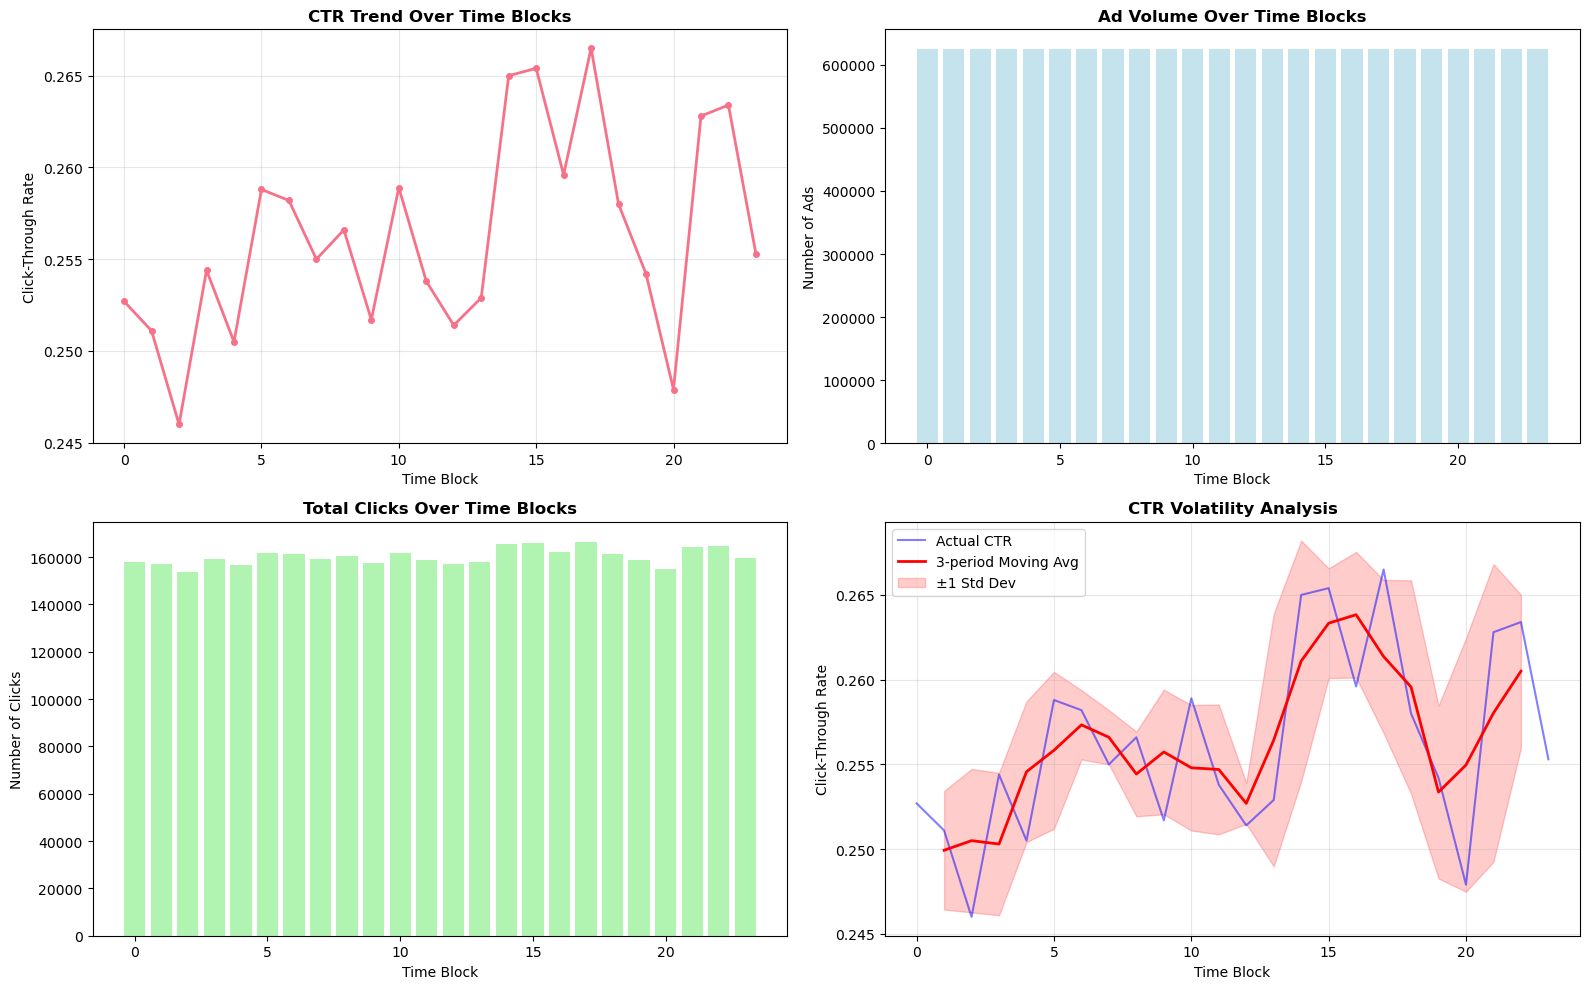


TEMPORAL STATISTICS:
Mean CTR across time blocks: 0.2563
CTR Variance: 0.000031
Coefficient of Variation: 0.0217
CTR Range: 0.2460 - 0.2665

TREND ANALYSIS:
Temporal trend slope: 0.000353
R-squared: 0.2021
P-value: 0.0275
Trend is increasing and significant


In [63]:
# Time-based Analysis (if time information is available)
print("TIME-BASED PATTERNS ANALYSIS")
print("=" * 60)

# Note: The dataset description mentions chronological ordering
# Let's analyze patterns based on row position as proxy for time
print("Analyzing temporal patterns using row position as time proxy...")

# Create time-based features
data['row_position'] = range(len(data))
data['time_block'] = pd.cut(data['row_position'], bins=24, labels=range(24))  # 24 time blocks

# CTR by time blocks
time_ctr = data.groupby('time_block')['click'].agg(['count', 'sum', 'mean']).round(4)
time_ctr.columns = ['Total_Ads', 'Clicks', 'CTR']

print("CTR by Time Blocks:")
print(time_ctr.head(10))

# Visualize temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# CTR over time
axes[0,0].plot(time_ctr.index.astype(int), time_ctr['CTR'], marker='o', linewidth=2, markersize=4)
axes[0,0].set_title('CTR Trend Over Time Blocks', fontweight='bold')
axes[0,0].set_xlabel('Time Block')
axes[0,0].set_ylabel('Click-Through Rate')
axes[0,0].grid(True, alpha=0.3)

# Volume over time
axes[0,1].bar(time_ctr.index.astype(int), time_ctr['Total_Ads'], color='lightblue', alpha=0.7)
axes[0,1].set_title('Ad Volume Over Time Blocks', fontweight='bold')
axes[0,1].set_xlabel('Time Block')
axes[0,1].set_ylabel('Number of Ads')

# Clicks over time
axes[1,0].bar(time_ctr.index.astype(int), time_ctr['Clicks'], color='lightgreen', alpha=0.7)
axes[1,0].set_title('Total Clicks Over Time Blocks', fontweight='bold')
axes[1,0].set_xlabel('Time Block')
axes[1,0].set_ylabel('Number of Clicks')

# CTR volatility
time_ctr['CTR_rolling_mean'] = time_ctr['CTR'].rolling(window=3, center=True).mean()
time_ctr['CTR_rolling_std'] = time_ctr['CTR'].rolling(window=3, center=True).std()

axes[1,1].plot(time_ctr.index.astype(int), time_ctr['CTR'], 'b-', alpha=0.5, label='Actual CTR')
axes[1,1].plot(time_ctr.index.astype(int), time_ctr['CTR_rolling_mean'], 'r-', linewidth=2, label='3-period Moving Avg')
axes[1,1].fill_between(time_ctr.index.astype(int), 
                       time_ctr['CTR_rolling_mean'] - time_ctr['CTR_rolling_std'],
                       time_ctr['CTR_rolling_mean'] + time_ctr['CTR_rolling_std'],
                       alpha=0.2, color='red', label='±1 Std Dev')
axes[1,1].set_title('CTR Volatility Analysis', fontweight='bold')
axes[1,1].set_xlabel('Time Block')
axes[1,1].set_ylabel('Click-Through Rate')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical analysis of temporal patterns
ctr_variance = time_ctr['CTR'].var()
ctr_mean = time_ctr['CTR'].mean()
coefficient_of_variation = time_ctr['CTR'].std() / ctr_mean

print(f"\nTEMPORAL STATISTICS:")
print(f"Mean CTR across time blocks: {ctr_mean:.4f}")
print(f"CTR Variance: {ctr_variance:.6f}")
print(f"Coefficient of Variation: {coefficient_of_variation:.4f}")
print(f"CTR Range: {time_ctr['CTR'].min():.4f} - {time_ctr['CTR'].max():.4f}")

# Test for temporal trend
from scipy import stats
time_blocks = time_ctr.index.astype(int)
ctr_values = time_ctr['CTR'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(time_blocks, ctr_values)

print(f"\nTREND ANALYSIS:")
print(f"Temporal trend slope: {slope:.6f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")
trend_direction = "increasing" if slope > 0 else "decreasing" if slope < 0 else "stable"
significance = "significant" if p_value < 0.05 else "not significant"
print(f"Trend is {trend_direction} and {significance}")

In [64]:
# Feature Engineering Insights
print("FEATURE ENGINEERING INSIGHTS")
print("=" * 60)

print("Based on EDA findings, here are recommended feature engineering steps:")
print()

# 1. Missing value handling insights
if len(features_with_missing) > 0:
    print("MISSING VALUES HANDLING:")
    print("   • Features with missing values identified")
    print("   • Consider creating 'is_missing' indicator features")
    print("   • Use domain-specific imputation (mode for categorical, median for numeric)")
    print("   • Missing values might be informative - test CTR difference")
    print()

# 2. Categorical encoding insights
print("CATEGORICAL ENCODING:")
high_card_features = cat_df[cat_df['Cardinality_Type'] == 'High']['Feature'].tolist()
medium_card_features = cat_df[cat_df['Cardinality_Type'] == 'Medium']['Feature'].tolist()
low_card_features = cat_df[cat_df['Cardinality_Type'] == 'Low']['Feature'].tolist()

print(f"   • High cardinality features ({len(high_card_features)}): Use target encoding or embeddings")
print(f"   • Medium cardinality features ({len(medium_card_features)}): Use label encoding or one-hot")
print(f"   • Low cardinality features ({len(low_card_features)}): Use one-hot encoding")
print("   • Consider frequency encoding for all categorical features")
print()

# 3. Integer features insights
print("INTEGER FEATURES TRANSFORMATION:")
print("   • Check for skewed distributions - consider log transformation")
print("   • Create binned versions for highly skewed features")
print("   • Consider polynomial features for non-linear relationships")
print("   • Scale features for neural networks")
print()

# 4. Feature interactions
print("FEATURE INTERACTIONS:")
if len(top_features) > 1:
    print(f"   • Create interaction terms between: {', '.join(top_features[:3])}")
print("   • Cross-categorical features combinations")
print("   • Ratio features (e.g., feature1/feature2)")
print()

# 5. Time-based features
print("TIME-BASED FEATURES:")
print("   • Extract time-based patterns (hour, day, weekend)")
print("   • Create lag features for sequential patterns")
print("   • Calculate moving averages for CTR by categories")
print()

# Create example engineered features
print("CREATING SAMPLE ENGINEERED FEATURES:")
print("=" * 50)

# Example 1: Missing value indicators
for feature in features_with_missing['Feature'][:3]:
    data[f'{feature}_is_missing'] = data[feature].isnull().astype(int)
    missing_ctr_impact = data.groupby(f'{feature}_is_missing')['click'].mean()
    print(f"✓ Created {feature}_is_missing | CTR Impact: {abs(missing_ctr_impact[1] - missing_ctr_impact[0]):.4f}")

# Example 2: Frequency encoding for categorical features
for feature in categorical_cols[:3]:
    freq_encoding = data[feature].value_counts().to_dict()
    data[f'{feature}_freq'] = data[feature].map(freq_encoding).fillna(0)
    freq_ctr_corr = data[[f'{feature}_freq', 'click']].corr().iloc[0,1]
    print(f"✓ Created {feature}_freq | Correlation with CTR: {freq_ctr_corr:.4f}")

# Example 3: Log transformation for skewed integer features
for feature in integer_cols[:2]:
    if data[feature].dropna().min() >= 0:  # Only for non-negative features
        data[f'{feature}_log'] = np.log1p(data[feature].fillna(0))
        log_ctr_corr = data[[f'{feature}_log', 'click']].corr().iloc[0,1]
        original_ctr_corr = data[[feature, 'click']].corr().iloc[0,1]
        improvement = abs(log_ctr_corr) - abs(original_ctr_corr)
        print(f"✓ Created {feature}_log | Correlation improvement: {improvement:.4f}")

print()
print("FEATURE ENGINEERING SUMMARY:")
print(f"   • Original features: {len(data.columns) - len([c for c in data.columns if '_' in c])}")
print(f"   • Engineered features: {len([c for c in data.columns if '_' in c])}")
print(f"   • Total features: {len(data.columns)}")

FEATURE ENGINEERING INSIGHTS
Based on EDA findings, here are recommended feature engineering steps:

MISSING VALUES HANDLING:
   • Features with missing values identified
   • Consider creating 'is_missing' indicator features
   • Use domain-specific imputation (mode for categorical, median for numeric)
   • Missing values might be informative - test CTR difference

CATEGORICAL ENCODING:
   • High cardinality features (15): Use target encoding or embeddings
   • Medium cardinality features (3): Use label encoding or one-hot
   • Low cardinality features (8): Use one-hot encoding
   • Consider frequency encoding for all categorical features

INTEGER FEATURES TRANSFORMATION:
   • Check for skewed distributions - consider log transformation
   • Create binned versions for highly skewed features
   • Consider polynomial features for non-linear relationships
   • Scale features for neural networks

FEATURE INTERACTIONS:
   • Create interaction terms between: I10, I11, I1
   • Cross-categori

In [ ]:
# Data Quality Assessment
print("DATA QUALITY ASSESSMENT")
print("=" * 60)

quality_issues = []

# 1. Duplicate rows check
print("DUPLICATE ROWS CHECK:")
duplicate_count = data.duplicated().sum()
duplicate_pct = (duplicate_count / len(data)) * 100
print(f"   Duplicate rows: {duplicate_count:,} ({duplicate_pct:.2f}%)")
if duplicate_count > 0:
    quality_issues.append(f"Duplicate rows: {duplicate_count:,}")

# 2. Data type consistency
print("\nDATA TYPE CONSISTENCY:")
type_issues = 0
for col in integer_cols:
    if data[col].dtype not in ['int8', 'int16', 'int32', 'int64', 'float64']:
        print(f"    {col} should be numeric but is {data[col].dtype}")
        type_issues += 1

if type_issues == 0:
    print("   All integer features have appropriate numeric types")

# 3. Value range validation
print("\nVALUE RANGE VALIDATION:")
range_issues = 0

# Check target variable
if data['click'].min() < 0 or data['click'].max() > 1:
    print("    Target variable 'click' has values outside [0,1] range")
    range_issues += 1
else:
    print("   Target variable has valid range [0,1]")

# Check for negative values in count features (assuming they should be non-negative)
for col in integer_cols[:5]:  # Check first 5 integer features
    if data[col].dropna().min() < 0:
        negative_count = (data[col] < 0).sum()
        print(f"    {col} has {negative_count} negative values")
        range_issues += 1

if range_issues == 0:
    print("   No unexpected negative values found")

# 4. Outlier detection
print("\n0OUTLIER DETECTION:")
outlier_summary = []

for col in integer_cols:
    col_data = data[col].dropna()
    if len(col_data) > 0:
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = ((col_data < lower_bound) | (col_data > upper_bound)).sum()
        outlier_pct = (outliers / len(col_data)) * 100
        
        outlier_summary.append({
            'Feature': col,
            'Outliers': outliers,
            'Outlier_Percentage': round(outlier_pct, 2),
            'Lower_Bound': round(lower_bound, 2),
            'Upper_Bound': round(upper_bound, 2)
        })

outlier_df = pd.DataFrame(outlier_summary)
high_outlier_features = outlier_df[outlier_df['Outlier_Percentage'] > 5]

if len(high_outlier_features) > 0:
    print("   Features with >5% outliers:")
    print(high_outlier_features[['Feature', 'Outlier_Percentage']].to_string(index=False))
else:
    print("   No features with excessive outliers (>5%)")

# 5. Cardinality validation
print("\nCARDINALITY VALIDATION:")
cardinality_issues = 0

# Check for categorical features with too many unique values
for feature in categorical_cols:
    unique_count = data[feature].nunique()
    unique_ratio = unique_count / len(data)
    
    if unique_ratio > 0.95:  # If >95% of values are unique
        print(f"    {feature} has very high cardinality: {unique_count:,} unique values ({unique_ratio:.2%})")
        cardinality_issues += 1

if cardinality_issues == 0:
    print("   No excessive cardinality issues found")

# 6. Missing value patterns
print("\nMISSING VALUE PATTERNS:")
if len(features_with_missing) > 0:
    # Check if any rows are completely missing
    completely_missing_rows = data.isnull().all(axis=1).sum()
    if completely_missing_rows > 0:
        print(f"    {completely_missing_rows} rows are completely missing")
    else:
        print("   No completely missing rows")
    
    # Check missing value concentration
    missing_per_row = data.isnull().sum(axis=1)
    high_missing_rows = (missing_per_row > len(data.columns) * 0.5).sum()
    if high_missing_rows > 0:
        print(f"    {high_missing_rows} rows missing >50% of values")
    else:
        print("   No rows with excessive missing values")
else:
    print("   No missing values found")

# 7. Target variable balance
print("\nTARGET VARIABLE BALANCE:")
click_ratio = data['click'].mean()
if click_ratio < 0.01 or click_ratio > 0.99:
    balance_issue = "severely imbalanced"
elif click_ratio < 0.05 or click_ratio > 0.95:
    balance_issue = "highly imbalanced"
elif click_ratio < 0.1 or click_ratio > 0.9:
    balance_issue = "imbalanced"
else:
    balance_issue = "relatively balanced"

print(f"   Target distribution: {balance_issue} (CTR: {click_ratio:.4%})")

# Data Quality Score
print("\nDATA QUALITY SCORE:")
print("=" * 30)
total_checks = 7
issues_found = len(quality_issues) + (1 if duplicate_count > 0 else 0) + type_issues + range_issues + cardinality_issues
quality_score = ((total_checks - issues_found) / total_checks) * 100

print(f"Overall Data Quality Score: {quality_score:.1f}/100")
if quality_score >= 90:
    print("Excellent data quality!")
elif quality_score >= 75:
    print("Good data quality")
elif quality_score >= 60:
    print(" Fair data quality - some issues to address")
else:
    print("Poor data quality - significant issues found")

print(f"\nIssues found: {issues_found}")
if quality_issues:
    print("Quality issues to address:")
    for issue in quality_issues:
        print(f"  • {issue}")

DATA QUALITY ASSESSMENT
DUPLICATE ROWS CHECK:
   Duplicate rows: 0 (0.00%)

DATA TYPE CONSISTENCY:
   All integer features have appropriate numeric types

VALUE RANGE VALIDATION:
   Target variable has valid range [0,1]
    I2 has 1553095 negative values

4️⃣ OUTLIER DETECTION:
   Features with >5% outliers:
Feature  Outlier_Percentage
     I1               12.03
     I2               15.94
     I3               10.42
     I4                6.58
     I5               13.20
     I6               11.35
     I7               12.66
     I9               10.32
    I11                9.60
    I12                6.64
    I13                8.45

CARDINALITY VALIDATION:
   No excessive cardinality issues found

MISSING VALUE PATTERNS:
   No completely missing rows
   No rows with excessive missing values

TARGET VARIABLE BALANCE:
   Target distribution: relatively balanced (CTR: 25.6248%)

DATA QUALITY SCORE:
Overall Data Quality Score: 85.7/100
Good data quality

Issues found: 1


In [66]:
# Key Findings and Recommendations
print("KEY FINDINGS & RECOMMENDATIONS")
print("=" * 60)

print("DATASET CHARACTERISTICS:")
print(f"   • Dataset size: {len(data):,} rows × {len(data.columns)} columns")
print(f"   • Click-through rate: {data['click'].mean():.4%}")
print(f"   • Class imbalance ratio: {(1-data['click'].mean())/data['click'].mean():.1f}:1")
print(f"   • Integer features: {len(integer_cols)}")
print(f"   • Categorical features: {len(categorical_cols)}")
print(f"   • Missing values: {'Yes' if len(features_with_missing) > 0 else 'No'}")

print("\nFEATURE INSIGHTS:")

# Top predictive integer features
if len(target_corr) > 0:
    print("   Most predictive integer features:")
    for i, (feature, corr) in enumerate(target_corr.head(3).items(), 1):
        print(f"     {i}. {feature}: correlation = {int_corr.loc[feature, 'click']:.4f}")

# Categorical features insights
if 'categorical_ctr_strength' in locals() and categorical_ctr_strength:
    print("   Most predictive categorical features:")
    for i, row in enumerate(cat_strength_df.head(3).itertuples(), 1):
        print(f"     {i}. {row.Feature}: Cramér's V = {row.Cramers_V:.4f}")

print("\n CHALLENGES IDENTIFIED:")
challenges = [
    "Highly imbalanced target variable (typical for CTR prediction)",
    "Large categorical feature cardinality requires careful encoding",
    "Missing values need strategic handling",
    "Potential temporal patterns need investigation",
    "Feature interactions should be explored"
]

for i, challenge in enumerate(challenges, 1):
    print(f"   {i}. {challenge}")

print("\nMODELING RECOMMENDATIONS:")
recommendations = [
    "Use stratified sampling to maintain class balance in train/test splits",
    "Implement SMOTE or adjust class weights to handle imbalance",
    "Focus on ROC-AUC and Precision-Recall metrics over accuracy",
    "Use target encoding for high-cardinality categorical features",
    "Consider ensemble methods (XGBoost, LightGBM) known to work well for CTR",
    "Implement cross-validation with temporal awareness",
    "Create interaction features between top predictive variables",
    "Use early stopping to prevent overfitting"
]

for i, rec in enumerate(recommendations, 1):
    print(f"   {i}. {rec}")

print("\nFEATURE ENGINEERING PRIORITIES:")
fe_priorities = [
    "Create missing value indicator features",
    "Implement frequency/target encoding for categorical features", 
    "Log-transform skewed integer features",
    "Generate interaction terms between top features",
    "Create time-based aggregation features",
    "Implement feature scaling/normalization",
    "Consider dimensionality reduction for high-cardinality features"
]

for i, priority in enumerate(fe_priorities, 1):
    print(f"   {i}. {priority}")

print("\nNEXT STEPS:")
next_steps = [
    "Implement comprehensive feature engineering pipeline",
    "Split data maintaining temporal order and class balance",
    "Start with baseline models (Logistic Regression, Random Forest)",
    "Progress to advanced models (XGBoost, Neural Networks)",
    "Implement proper validation strategy with time-based splits",
    "Optimize for business metrics (CTR prediction accuracy)",
    "Build ad scoring and ranking system",
    "Create deployment pipeline for real-time predictions"
]

for i, step in enumerate(next_steps, 1):
    print(f"   {i}. {step}")

# Save key statistics for future reference
key_stats = {
    'dataset_size': len(data),
    'num_features': len(data.columns) - 1,
    'ctr': data['click'].mean(),
    'missing_features': len(features_with_missing),
    'top_correlated_features': target_corr.head(5).to_dict() if len(target_corr) > 0 else {},
    'quality_score': quality_score
}

print(f"\nKEY STATISTICS SAVED:")
for key, value in key_stats.items():
    if isinstance(value, dict):
        print(f"   {key}: {list(value.keys())}")
    else:
        print(f"   {key}: {value}")

print("\n" + "="*60)
print("EDA COMPLETED SUCCESSFULLY!")
print("Ready to proceed with Feature Engineering and Modeling phases")
print("="*60)

KEY FINDINGS & RECOMMENDATIONS
DATASET CHARACTERISTICS:
   • Dataset size: 14,999,925 rows × 49 columns
   • Click-through rate: 25.6248%
   • Class imbalance ratio: 2.9:1
   • Integer features: 13
   • Categorical features: 26
   • Missing values: Yes

FEATURE INSIGHTS:
   Most predictive integer features:
     1. I10: correlation = 0.1745
     2. I11: correlation = 0.1558
     3. I1: correlation = 0.0922
   Most predictive categorical features:
     1. C3: Cramér's V = 0.5980
     2. C4: Cramér's V = 0.3960
     3. C7: Cramér's V = 0.2814

 CHALLENGES IDENTIFIED:
   1. Highly imbalanced target variable (typical for CTR prediction)
   2. Large categorical feature cardinality requires careful encoding
   3. Missing values need strategic handling
   4. Potential temporal patterns need investigation
   5. Feature interactions should be explored

MODELING RECOMMENDATIONS:
   1. Use stratified sampling to maintain class balance in train/test splits
   2. Implement SMOTE or adjust class wei

In [67]:
# Memory cleanup
print("CLEANING UP MEMORY...")

# Remove temporary columns created during EDA
temp_cols = [col for col in data.columns if any(suffix in col for suffix in ['_is_missing', '_freq', '_log', 'time_block', 'row_position'])]
if temp_cols:
    data.drop(temp_cols, axis=1, inplace=True)
    print(f"Removed {len(temp_cols)} temporary columns")

# Force garbage collection
gc.collect()

print(f"Final dataset shape: {data.shape}")
print(f"Final memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print("Memory cleanup completed")

CLEANING UP MEMORY...
Removed 9 temporary columns
Final dataset shape: (14999925, 40)
Final memory usage: 21597.8 MB
Memory cleanup completed
